In [24]:
%reload_ext autoreload
%autoreload 2

In [25]:
import os
import sys
if os.path.join(os.getcwd(), "..") not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), ".."))

In [26]:
# !pip install -q -r ../requirements.dev.txt

## Imports & Functions

In [27]:
# system lib
import itertools
import os
import time
from collections import defaultdict
from datetime import datetime
from typing import Dict, List, Optional

        
# import python packages  
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from tqdm.auto import tqdm

  
# import local packages
from src.constant import Chain
from src.erc20 import Token
from src.utils import print_log
from utils import (
    CacheUtils, 
    DataUtils, 
    ProcessingUtils, 
    Utility,
    VisualizeUtils,
    CAMPAIGN_START_DATETIME
)

# load dotenv
if load_dotenv():
    print_log(".env file loaded")
    
CHAINS = [
    Chain.ARBITRUM_ONE, Chain.OPTIMISM, 
    Chain.BNB_CHAIN, Chain.POLYGON, Chain.GNOSIS]
    
LP_TOKENS = [Token.CUSDCLP, Token.CWETHLP]

.env file loaded


## Load Data

In [28]:
LP_TOKENS = [Token.CWETHLP, Token.CUSDCLP, Token.CUSDTLP, Token.CDAILP]
MIN_VALUE = 1e-7
TIMEFRAME = "1T" # 1 minutes
THRESHOLD = 0.3

In [29]:
for chain in CHAINS:
    CacheUtils.save_cache(chain, reload=True)

dataset = DataUtils.load_dataset(CHAINS)
all_chains_data = pd.concat(dataset.values()).set_index("datetime").sort_index()
all_chains_data["balance_change"] = all_chains_data["token_amount"].copy() \
    * all_chains_data["action"].copy().map(lambda x: 1 if x in ["mint", "transfer_in"] else -1)

Reloading data...
Cache saved successfully!
Reloading data...
Cache saved successfully!
Reloading data...
Cache saved successfully!
Reloading data...
Cache saved successfully!
Reloading data...
Cache saved successfully!
Cache loaded successfully!
Data loaded from chain arbitrum_one, total of 24738 record
Cache loaded successfully!
Data loaded from chain optimism, total of 6535 record
Cache loaded successfully!
Data loaded from chain bnb_chain, total of 3591 record
Cache loaded successfully!
Data loaded from chain polygon, total of 14454 record
Cache loaded successfully!
Data loaded from chain gnosis, total of 2357 record


In [30]:
LATEST_DATE = all_chains_data.index.max()
LATEST_DATE

Timestamp('2023-05-04 14:49:54')

In [33]:
all_chains_data["token"].unique()

array(['CUSDCLP', 'CWETHLP', 'CUSDTLP', 'CDAILP'], dtype=object)

In [8]:
def calculate_average_balance_by_minute(user_balance):
    temp = pd.Series(data=[0., 0.], index=[CAMPAIGN_START_DATETIME, LATEST_DATE], name="balance_change")
    balance_resampled = pd.concat(
        [user_balance, temp]
    ).sort_index().cumsum().resample("T").last().ffill().between_time(
        CAMPAIGN_START_DATETIME.time(), 
        LATEST_DATE.time())
    score = balance_resampled.mean()
    del balance_resampled
    return score


def get_lp_holdings_day(
    user_balance: pd.Series,
    min_value: float = MIN_VALUE,
) -> int:
    total_seconds = 0
    
    temp = pd.Series(data=[0., 0.], index=[CAMPAIGN_START_DATETIME, LATEST_DATE], name="balance_change")
    balance_resampled = pd.concat(
        [user_balance, temp]
    ).sort_index().cumsum()
    user_balance = balance_resampled[balance_resampled.index >= CAMPAIGN_START_DATETIME]

    init_balance = user_balance.iloc[0]
    running_start = user_balance.index[0]
    for i in range(len(user_balance)-1):
        curr, nxt = user_balance.iloc[i], user_balance.iloc[i+1]
        if curr == 0 and nxt > 0:
            # add liquidity
            running_start = user_balance.index[i+1]
        elif curr > 0 and nxt == 0:
            # remove liquidity
            duration = user_balance.index[i+1] - running_start
            total_seconds += duration.total_seconds()
            running_start = None
    if running_start:
        total_seconds = (LATEST_DATE - running_start).total_seconds()
    return Utility.get_days_from_second(total_seconds)


def query_user(
    query: str, 
    all_chains_data: Optional[pd.DataFrame] = None,
    min_usdc_value: float = 0, 
    min_weth_value: float = 0,
    threshold: float = 0.3
) -> None:
    global user_scores
    query = query.lower().strip()
    
    if min_usdc_value > 0:
        print(f"Applying filter for with {min_usdc_value} CUSDCLP")
    if min_weth_value > 0:
        print(f"Applying filter for with {min_weth_value} CWETHLP")
    
    if not (("user_scores" in locals()) or ("user_scores" in globals())):
        st = time.time()
        user_scores = all_chains_data.groupby(["chain", "user_address", "token"], as_index=False)["balance_change"].apply(
            calculate_average_balance_by_minute
        )
        print_log(f"Aggregating data finished in {time.time() - st:.2f} seconds\n")
    
    print(f"Querying {query}\n")
    for chain, token in itertools.product(CHAINS, LP_TOKENS):
        min_value = min_usdc_value if token == Token.CUSDCLP else min_weth_value
        chain = Chain.resolve_connext_domain(chain)
        _score = user_scores[(user_scores["chain"] == chain) & (user_scores["token"] == token)].sort_values(
            "balance_change", ascending=False).reset_index(drop=True)
        qualified = _score.iloc[:round(len(_score[_score["balance_change"] > min_value]) * threshold)]
        user_results = qualified[qualified["user_address"] == query]
        
        if len(user_results) > 0:
            print(f"Qualified for {token} on {chain}")
            print(f"Found at rank {user_results.index[0]} / {len(qualified)}")
            print(f"Provided {user_results.values[-1][-1]} {token}")
            print()
            
            
def plot_user(user_txs: pd.DataFrame) -> None:
    if len(user_txs["token"].unique()) == 1:
    
        fig, ax = plt.subplots(1, 1, figsize=(13, 4))
        _token = user_txs["token"].unique()[0]

        temp = pd.Series(
            data=[0., 0.], 
            index=[CAMPAIGN_START_DATETIME, LATEST_DATE], 
            name="balance_change")
        for _chain in list(map(Chain.resolve_connext_domain, CHAINS)):
            _data = all_chains_data[
                (all_chains_data["user_address"] == query.lower()) & \
                (all_chains_data["chain"] == _chain) & \
                (all_chains_data["token"] == _token)
            ]
            if len(_data) > 0:
                _data = pd.concat([_data, pd.DataFrame([{
                    "hash": "",
                    "user_address": query,
                    "token_amount": 0,
                    "action": "",
                    "balance_change": 0
                }, {
                    "hash": "",
                    "user_address": query,
                    "token_amount": 0,
                    "action": "",
                    "balance_change": 0
                }], index=[CAMPAIGN_START_DATETIME, LATEST_DATE])], axis=0)
                _data = _data.sort_index()
                _data = _data["balance_change"].cumsum().resample(TIMEFRAME).last().ffill()
                _data = _data[_data.index >= CAMPAIGN_START_DATETIME]
                _data.plot(ax=ax, label=_chain)
                ax.legend()
            ax.set_title(f"{_token} Balance")
    elif len(user_txs["token"].unique()) > 1:

        fig, ax = plt.subplots(1, 2, figsize=(13, 4))

        temp = pd.Series(
            data=[0., 0.], 
            index=[CAMPAIGN_START_DATETIME, LATEST_DATE], 
            name="balance_change")
        for i, _token in enumerate(LP_TOKENS):
            for _chain in list(map(Chain.resolve_connext_domain, CHAINS)):
                _data = all_chains_data[
                    (all_chains_data["user_address"] == query.lower()) & \
                    (all_chains_data["chain"] == _chain) & \
                    (all_chains_data["token"] == _token)
                ]
                if len(_data) > 0:
                    _data = pd.concat([_data, pd.DataFrame([{
                        "hash": "",
                        "user_address": query,
                        "token_amount": 0,
                        "action": "",
                        "balance_change": 0
                    }, {
                        "hash": "",
                        "user_address": query,
                        "token_amount": 0,
                        "action": "",
                        "balance_change": 0
                    }], index=[CAMPAIGN_START_DATETIME, LATEST_DATE])], axis=0)
                    _data = _data.sort_index()
                    _data = _data["balance_change"].cumsum().resample(TIMEFRAME).last().ffill()
                    _data = _data[_data.index >= CAMPAIGN_START_DATETIME]
                    _data.plot(ax=ax[i], label=_chain)
                    ax[i].legend()
            ax[i].set_title(f"{_token} Balance")
    fig.suptitle(query)

In [9]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

In [10]:
temp = pd.Series(data=[0., 0.], index=[CAMPAIGN_START_DATETIME, LATEST_DATE], name="balance_change")

for (_chain, _addr, _token), x in list(all_chains_data.groupby(["chain", "user_address", "token"], as_index=False)["balance_change"]):
    if len(x) > 10:
        break

In [11]:
balance_resampled = pd.concat(
        [x, temp]
    ).sort_index().cumsum().resample("T").last().ffill().between_time(
        CAMPAIGN_START_DATETIME.time(), 
        LATEST_DATE.time())

In [12]:
st = time.time()
user_scores = all_chains_data.groupby(["chain", "user_address", "token"], as_index=False)["balance_change"].apply(
    calculate_average_balance_by_minute
)
print(f"Scores calculated within {time.time() - st:.2f} seconds")

Scores calculated within 48.70 seconds


## Calculate Scores

In [106]:
all_chains_data.groupby(
    ["user_address", "chain", "token"], 
    as_index=False
)["balance_change"].sum().groupby(
    ["chain", "token"],
    as_index=False
).apply(lambda x: x["balance_change"][x["balance_change"] > MIN_VALUE].sort_values(
    ascending=False
).iloc[:round(
    len(x["balance_change"][x["balance_change"] > MIN_VALUE]) * 0.3
)].values[-1])

,chain,token,None
0,arbitrum_one,CUSDCLP,1112.509560
1,arbitrum_one,CWETHLP,0.109775
2,bnb_chain,CUSDCLP,2201.040545
3,bnb_chain,CWETHLP,1.720172
4,gnosis,CUSDCLP,1355.764832
5,gnosis,CWETHLP,2.003913
6,optimism,CUSDCLP,1689.596817
7,optimism,CWETHLP,0.997230
8,polygon,CUSDCLP,1068.915199
9,polygon,CWETHLP,0.905805


In [115]:
query = "0xc5Dfbcf2461c0eDC8d0f98D8b0eD9B9fC8B86Af9".lower()
# query = "0x66633Cc6B84CD127A0bb84864c1a4eA0172469A6".lower()
# query = "0xCEdf866187680e70296a8b9EEce22A09b4F05798"

query = "0xe9b14a1be94e70900eddf1e22a4cb8c56ac9e10a".lower()

user_txs = all_chains_data[all_chains_data["user_address"] == query.lower()]

In [116]:
chain = "optimism"
token = "CUSDCLP"
token_filter = 10


scores_data = user_scores[
    (user_scores["chain"] == chain) & \
    (user_scores["token"] == token)
].sort_values(
    "balance_change", 
    ascending=False
).set_index("user_address")["balance_change"]
scores_data = scores_data[scores_data > MIN_VALUE]
filtered_scores_data = scores_data[scores_data > token_filter]

user_score = scores_data[query]
min_score = scores_data.iloc[:round(0.3 * len(scores_data))].values[-1]
min_score_filter = filtered_scores_data.iloc[:round(0.3 * len(filtered_scores_data))].values[-1]

In [138]:
min_score_filter

1179.9188982943042

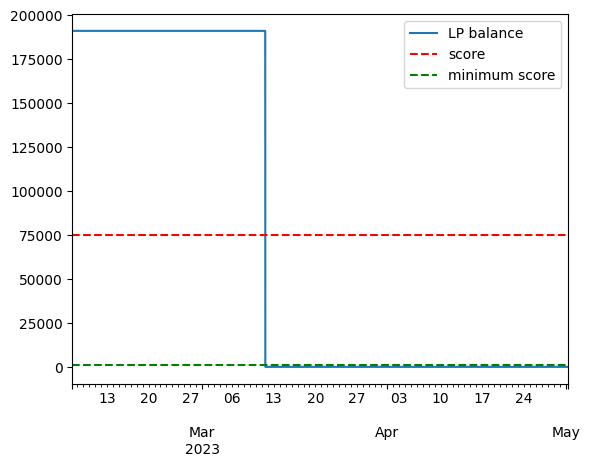

In [117]:
fig, ax = plt.subplots()
pd.concat([
    temp, 
    all_chains_data[
    (all_chains_data["chain"] == chain) & \
    (all_chains_data["token"] == token) & \
    (all_chains_data["user_address"] == query.lower())
]], axis=0)["balance_change"].cumsum().resample("T").last().ffill().plot(ax=ax, label="LP balance")
ax.axhline(user_score, linestyle="--", color="red", label="score")
ax.axhline(min_score, linestyle="--", color="green", label="minimum score")
ax.legend()

In [135]:
1450 / len(all_chains_data[
    (all_chains_data["chain"] == chain) & \
    (all_chains_data["token"] == token)
])

0.26121419564042514

<Axes: ylabel='Frequency'>

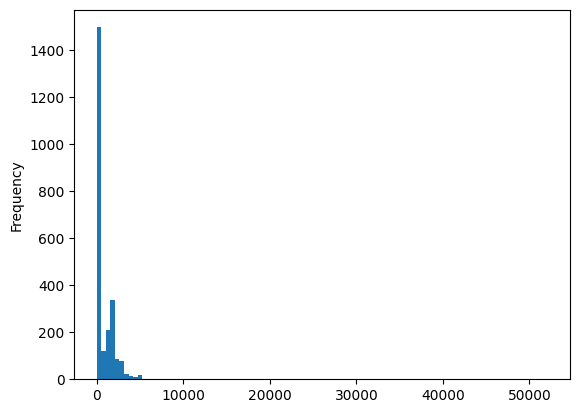

In [136]:
all_chains_data[
    (all_chains_data["chain"] == chain) & \
    (all_chains_data["token"] == token)
].groupby("user_address")["balance_change"].sum().plot.hist(bins=100)

In [118]:
min_score

968.9426171125874

In [70]:
all_chains_data[
    (all_chains_data["chain"] == chain) & \
    (all_chains_data["token"] == token)].groupby(["user_address"], as_index=False)["balance_change"].cumsum()

datetime
2022-12-22 21:02:19        2.000000
2022-12-23 00:18:24      502.000000
2022-12-24 01:22:52      501.000000
2023-01-04 15:53:00    49994.925996
2023-01-05 22:47:56        0.799494
                           ...     
2023-05-01 03:10:26        0.000000
2023-05-01 03:20:02        0.000000
2023-05-01 04:28:04        0.000000
2023-05-01 06:55:54     2781.874159
2023-05-01 07:31:22     1641.959116
Name: balance_change, Length: 5551, dtype: float64

In [45]:
user_score

74991.75137070684

In [46]:
user_txs

,chain,hash,user_address,token,token_amount,action,balance_change
datetime,,,,,,,
2023-02-07 05:07:08,optimism,0xca96de100d07dd464367128d6be4b01ff154058f42d8...,0xe9b14a1be94e70900eddf1e22a4cb8c56ac9e10a,CUSDCLP,190888.094398,mint,190888.094398
2023-02-08 17:46:50,arbitrum_one,0x2502d8963203109d26ca3b34878c552847fd00518e1a...,0xe9b14a1be94e70900eddf1e22a4cb8c56ac9e10a,CWETHLP,98.383791,mint,98.383791
2023-03-11 13:50:58,optimism,0xe532718a00fe1b3a25ffdcd2b96e80f54705590d10d1...,0xe9b14a1be94e70900eddf1e22a4cb8c56ac9e10a,CUSDCLP,190888.094398,burn,-190888.094398
2023-04-27 15:55:24,arbitrum_one,0xe990346ac01114fbb4319d0110bfb529216e3164950f...,0xe9b14a1be94e70900eddf1e22a4cb8c56ac9e10a,CWETHLP,98.383791,burn,-98.383791


In [47]:
scores_data[scores_data > 1].iloc[:20]

user_address
0xe9b14a1be94e70900eddf1e22a4cb8c56ac9e10a    74991.751371
0x3576aafaffe4c07f894447265b391856377157db    52137.741598
0xd78c323477500744214f662c15c82895a0bbdae9    49994.925996
0x391891af67e29d97e61e30c3036a0874f5da411e    49895.443024
0xb72ed8401892466ea8af528c1af1d0524bc5e105    46055.633306
0xd152f549545093347a162dce210e7293f1452150    18888.381579
0xfe950de30f2a8f9fc3cdfaa50c8e9cc99d8136ec    13571.313858
0xe3939654deae5f54fd3e6b84b3a7f75f245062d8     9827.426059
0x570fc0f42eac039de4b74c23fed65eff0080c858     9441.526371
0xedff3e9b6d596501c7fe806ef26bff395c01bdbe     9401.920720
0x997b86481ea10a414ac34acbcf1e3030274a618d     9370.653997
0x14ff0bc9417b6796f79768729002a793b51205b8     9308.507705
0x5ae4cfad1a656e9be2addc42750015e220fd6524     9179.369596
0x168f87fbfe36b84e44b9d06278b2aa1cc73d7400     8093.550548
0x7eb12f04effc4901d7520e4ebd62de512743feca     8045.764883
0xafbc2f75016d940fb457b836ccfcb781973b0e17     6834.812102
0x9c3c6cf9d29ab9e9e14503dbfc9ad8bb2a0e37ef 

Querying 0x3bc7d7a271b5c3167ecbc43d66053886ffaffa01

Qualified for CUSDCLP on arbitrum_one
Found at rank 1459 / 1972
Provided 826.6580905489606 CUSDCLP

Qualified for CUSDCLP on optimism
Found at rank 614 / 712
Provided 1018.4688822550198 CUSDCLP

Qualified for CUSDCLP on bnb_chain
Found at rank 89 / 421
Provided 2160.1156758095162 CUSDCLP

Qualified for CUSDCLP on polygon
Found at rank 964 / 1691
Provided 794.4757055746994 CUSDCLP

Qualified for CUSDCLP on gnosis
Found at rank 27 / 345
Provided 3115.071134108047 CUSDCLP

++++++++++++++++++++
Applying filter for with 10 CUSDCLP
Applying filter for with 0.05 CWETHLP
Querying 0x3bc7d7a271b5c3167ecbc43d66053886ffaffa01

Qualified for CUSDCLP on bnb_chain
Found at rank 89 / 283
Provided 2160.1156758095162 CUSDCLP

Qualified for CUSDCLP on polygon
Found at rank 964 / 992
Provided 794.4757055746994 CUSDCLP

Qualified for CUSDCLP on gnosis
Found at rank 27 / 164
Provided 3115.071134108047 CUSDCLP

++++++++++++++++++++


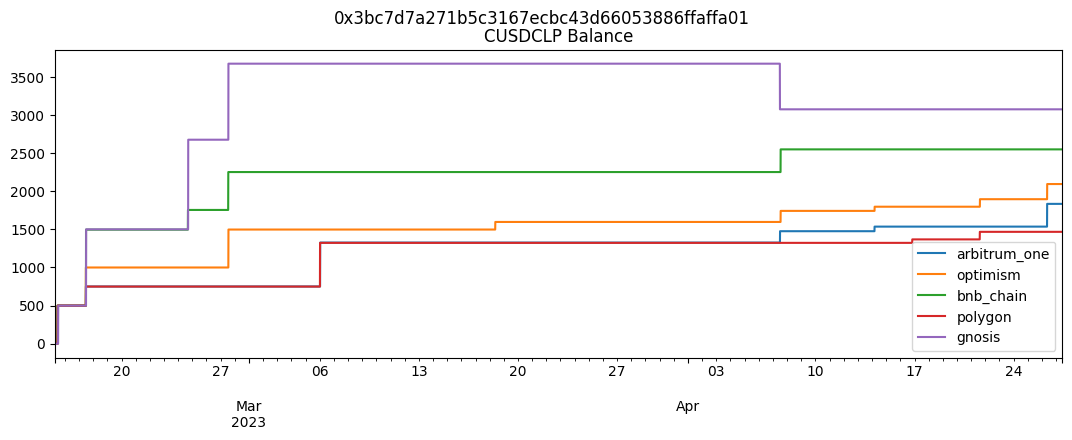

In [19]:
query_user(
    query,
    min_usdc_value=0,
    min_weth_value=0
)

print("+"*20)

query_user(
    query,
    min_usdc_value=10,
    min_weth_value=0.05
)

plot_user(user_txs)

print("+"*20)

## Analysis

## Statistics Aggregated for all chains

In [32]:
user_days = all_chains_data.groupby(["chain", "user_address", "token"], as_index=False)["balance_change"].apply(
    get_lp_holdings_day
)

user_balances = all_chains_data.groupby(["chain", "user_address", "token"], as_index=False)["balance_change"].apply(
    lambda x: x.cumsum()[-1]
)

user_infos = pd.merge(user_days, user_balances, on=["chain", "user_address", "token"])
user_infos.columns = ["chain", "user_address", "token", "elapsed_day", "balance"]
user_infos = user_infos[user_infos["balance"] > MIN_VALUE]

In [33]:
print("Number of unique wallet address:", len(user_balances[user_balances["balance_change"] > MIN_VALUE]["user_address"].unique()))

Number of unique wallet address: 16230


In [34]:
print("Total CUSDCLP minted", user_infos[user_infos["token"] == Token.CUSDCLP]["balance"].sum())
print("Total CWETHLP minted", user_infos[user_infos["token"] == Token.CWETHLP]["balance"].sum())

Total CUSDCLP minted 12611506.743203796
Total CWETHLP minted 2528.2767669891937


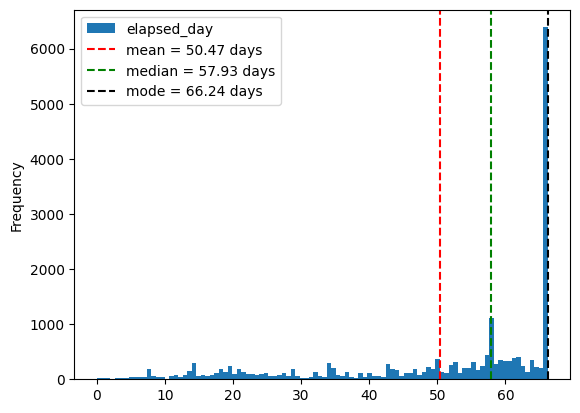

In [35]:
fig, ax = plt.subplots()
user_infos["elapsed_day"].plot.hist(bins=100, ax=ax)
mean = user_infos["elapsed_day"].mean()
median = user_infos["elapsed_day"].median()
mode = user_infos["elapsed_day"].mode()[0]

ax.axvline(mean, linestyle="--", color="red", label=f"mean = {mean:.2f} days")
ax.axvline(median, linestyle="--", color="green", label=f"median = {median:.2f} days")
ax.axvline(mode, linestyle="--", color="black", label=f"mode = {mode:.2f} days")
plt.legend()
plt.show()

In [37]:
user_infos["elapsed_day"].mean()

50.468414089401186

In [57]:
len(user_infos)

20727

In [53]:
(user_infos["elapsed_day"] > 30).sum()

16908

In [54]:
len(user_infos)

20727

In [52]:
(user_infos["elapsed_day"] > 30).sum() / len(user_infos)

0.8157475756259951

In [49]:
user_infos[user_infos["elapsed_day"] > 30].groupby("chain")["elapsed_day"].count().sort_index() / user_infos.groupby("chain")["elapsed_day"].count().sort_index()

chain
arbitrum_one    0.817639
bnb_chain       0.828397
gnosis          0.838208
optimism        0.835081
polygon         0.793011
Name: elapsed_day, dtype: float64

In [42]:
user_infos.groupby("chain")["elapsed_day"]

chain
arbitrum_one    49.562682
gnosis          50.166859
polygon         51.495688
bnb_chain       52.094611
optimism        52.670636
Name: elapsed_day, dtype: float64

In [398]:
user_infos[["balance", "elapsed_day"]].describe()

,balance,elapsed_day
count,2.068700e+04,20687.000000
mean,6.083937e+02,49.441158
std,2.430120e+03,17.946613
min,1.195639e-07,-0.290880
25%,1.029478e-02,39.090775
50%,1.010778e+00,56.820833
75%,9.051481e+02,65.104167
max,1.419882e+05,65.104167


In [467]:
lp_dist = user_balances.groupby("token")["balance_change"].sum()

In [470]:
lp_dist[Token.CWETHLP] = lp_dist[Token.CWETHLP] * 1900

Text(0.5, 1.0, 'LP Distribution in USDC')

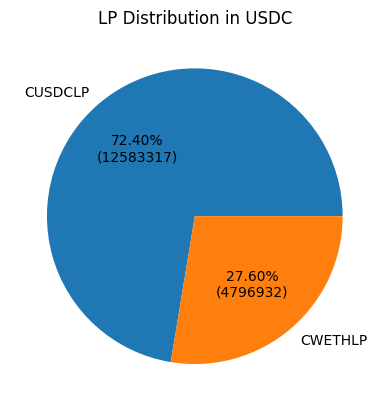

In [475]:
values = lp_dist.values
plt.pie(values, labels=lp_dist.index, autopct=make_autopct(values))
plt.title("LP Distribution in USDC")

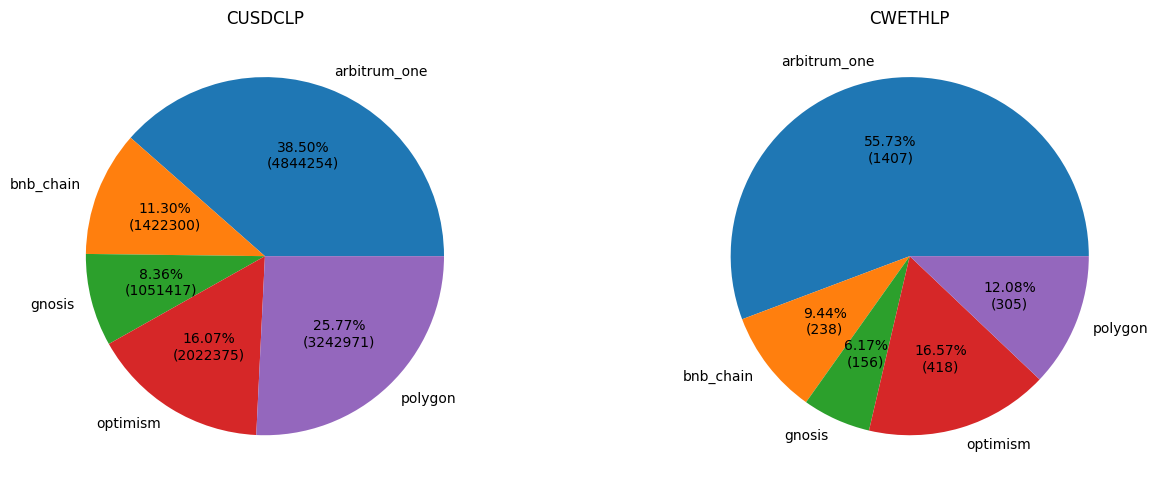

In [447]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

values = user_balances.groupby(["chain", "token"], as_index=False)["balance_change"].sum().sort_values("token").iloc[:5].set_index("chain")["balance_change"]
ax[0].pie(values, labels=values.index, autopct=make_autopct(values))
ax[0].set_title(Token.CUSDCLP)


values = user_balances.groupby(["chain", "token"], as_index=False)["balance_change"].sum().sort_values("token").iloc[5:].set_index("chain")["balance_change"]
ax[1].pie(values, labels=values.index, autopct=make_autopct(values))
ax[1].set_title(Token.CWETHLP)

plt.tight_layout()
plt.show()

In [418]:
user_balances[user_balances["token"] == Token.CUSDCLP]["balance_change"].sum()

12583316.69728255

In [419]:
user_balances[user_balances["token"] == Token.CWETHLP]["balance_change"].sum()

2524.700660726707

In [421]:
user_balances[user_balances["token"] == Token.CUSDCLP]["balance_change"].sum() + (user_balances[user_balances["token"] == Token.CWETHLP]["balance_change"].sum()*1904)

17390346.7553062

In [420]:
12*1e6 + (2500 * 1800)

16500000.0

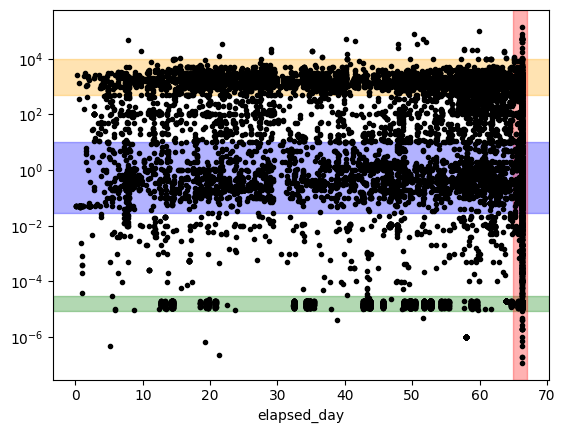

In [217]:
fig, ax = plt.subplots()

user_infos.set_index("elapsed_day")["balance"].plot(style=".", ax=ax, color="black")
# ax.axvspan(0, 30, color="red", label="LP < 30 days", alpha=0.3)
ax.axhspan(9e-6, 3e-5, color="green", label="Small liquidity provider/tester", alpha=0.3)
ax.axhspan(3e-2, 10, color="blue", label="LP 0.03 - 25 USDC", alpha=0.3)
ax.axhspan(500, 10000, color="orange", label="LP 0.03 - 25 USDC", alpha=0.3)
ax.axvspan(65, 67, color="red", label="LP 0.03 - 25 USDC", alpha=0.3)
ax.set_yscale("log")

In [159]:
import seaborn as sns

In [481]:
user_balances[(user_balances["balance_change"] > MIN_VALUE) & (user_balances["token"] == Token.CUSDCLP)]["balance_change"].describe()

count    1.286700e+04
mean     9.779526e+02
std      3.022174e+03
min      2.000000e-07
25%      1.010795e+00
50%      2.065040e+02
75%      1.395386e+03
max      1.419882e+05
Name: balance_change, dtype: float64

In [510]:
def group_usdc_lp(balance: float) -> str:
    if balance <= 0.1:
        return "(-inf, 0.1]"
    elif 0.1 < balance <= 10:
        return "(0.1, 10]"
    elif 10 < balance <= 100:
        return "(10, 100]"
    elif 100 < balance <= 1000:
        return "(100, 1000]"
    elif 1000 < balance <= 10000:
        return "(1000, 10000]"
    else:
        return "(10000, inf)"
    
    
def group_weth_lp(balance: float) -> str:
    if balance <= 0.001:
        return "(-inf, 0.001]"
    elif 0.001 < balance <= 0.01:
        return "(0.001, 0.01]"
    elif 0.01 < balance <= 0.1:
        return "(0.01, 0.1]"
    elif 0.1 < balance <= 1:
        return "(0.1, 1]"
    elif 1 < balance <= 10:
        return "(1, 10]"
    else:
        return "(10, inf)"

In [516]:
weth_bins = user_balances[(user_balances["balance_change"] > MIN_VALUE) & (user_balances["token"] == Token.CWETHLP)]["balance_change"].map(group_weth_lp).value_counts()
weth_bins = weth_bins[[
    "(-inf, 0.001]",
    "(0.001, 0.01]",
    "(0.01, 0.1]",
    "(0.1, 1]",
    "(1, 10]",
    "(10, inf)"]]

usdc_bins = user_balances[(user_balances["balance_change"] > MIN_VALUE) & (user_balances["token"] == Token.CUSDCLP)]["balance_change"].map(group_usdc_lp).value_counts()
usdc_bins = usdc_bins[[
    "(-inf, 0.1]",
    "(0.1, 10]",
    "(10, 100]",
    "(100, 1000]",
    "(1000, 10000]",
    "(10000, inf)"]]

Text(0.5, 1.0, 'Distribution of WETH Position')

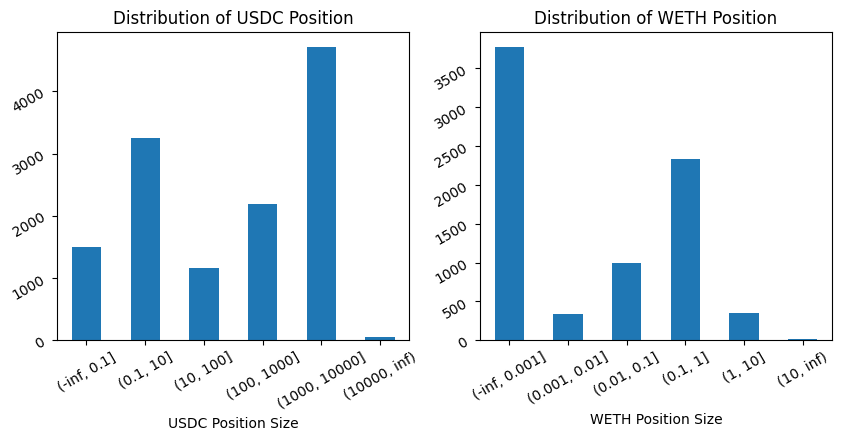

In [540]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

usdc_bins.plot.bar(ax=ax[0])
weth_bins.plot.bar(ax=ax[1])
ax[0].tick_params(rotation=30)
ax[0].set_xlabel("USDC Position Size")
ax[0].set_title("Distribution of USDC Position")
ax[1].tick_params(rotation=30)
ax[1].set_xlabel("WETH Position Size")
ax[1].set_title("Distribution of WETH Position")

In [541]:
weth_bins

balance_change
(-inf, 0.001]    3777
(0.001, 0.01]     334
(0.01, 0.1]      1000
(0.1, 1]         2335
(1, 10]           356
(10, inf)          18
Name: count, dtype: int64

In [542]:
usdc_bins

balance_change
(-inf, 0.1]      1501
(0.1, 10]        3243
(10, 100]        1163
(100, 1000]      2190
(1000, 10000]    4713
(10000, inf)       57
Name: count, dtype: int64

In [545]:
user_scores

,chain,user_address,token,balance_change
0,arbitrum_one,0x0000000000000000000000000000000000000001,CUSDCLP,1.000000e-15
1,arbitrum_one,0x0000000000000000000000000000000000000001,CWETHLP,1.000000e-15
2,arbitrum_one,0x000666f5f68b57c6f9272fd1342a4d55b33b4841,CUSDCLP,2.550713e+01
3,arbitrum_one,0x000758ac87b4a2cb96a2b43652e5c31b72ef92e8,CWETHLP,5.998667e-01
4,arbitrum_one,0x000bec82c41837d974899b26b26f9cc8890af9ea,CUSDCLP,2.103675e+00
...,...,...,...,...
25996,polygon,0xffe24db75c85d2cc14dd490c47f91f1519d23894,CUSDCLP,1.502064e-03
25997,polygon,0xffecdd96cf3e9ce3492197eb7fcd834f2e070df3,CUSDCLP,9.928759e-01
25998,polygon,0xfff6c7a5d0c2616d92e4f017c278b288fca62eec,CUSDCLP,1.592553e-03
25999,polygon,0xfffa889f71003f256f0e14b48e54fa2dad1f2ff0,CUSDCLP,3.387696e+02


In [74]:
(chain, token), value = list(user_balances.groupby(["chain", "token"]).balance_change)[0]

In [89]:
user_balances[user_balances["balance_change"] > MIN_VALUE].groupby(["chain", "token"], as_index=False).balance_change.mean().set_index("token").loc[Token.CUSDCLP].set_index("chain").sort_values("balance_change")

,balance_change
chain,
polygon,767.837805
arbitrum_one,998.325609
gnosis,1028.283688
optimism,1155.884410
bnb_chain,1389.230896


In [90]:
user_balances[user_balances["balance_change"] > MIN_VALUE].groupby(["chain", "token"], as_index=False).balance_change.mean().set_index("token").loc[Token.CWETHLP].set_index("chain").sort_values("balance_change")

,balance_change
chain,
arbitrum_one,0.200457
optimism,1.205689
polygon,1.265916
bnb_chain,1.938527
gnosis,2.133763


In [94]:
user_balances.groupby("chain").count()["user_address"].sort_values()

chain
gnosis           1310
bnb_chain        1601
optimism         2865
polygon          5918
arbitrum_one    14321
Name: user_address, dtype: int64

In [76]:
value.describe()

count    6.661000e+03
mean     7.279489e+02
std      3.113141e+03
min     -3.637979e-12
25%      0.000000e+00
50%      9.987373e+00
75%      1.015107e+03
max      1.419882e+05
Name: balance_change, dtype: float64

In [111]:
all_chains_data[
    (all_chains_data.index >= datetime.strptime("2023-03-10", "%Y-%m-%d")) & \
    (all_chains_data.index <= datetime.strptime("2023-03-14", "%Y-%m-%d")) & \
    (all_chains_data["token"] == Token.CUSDCLP)
]["balance_change"].sum()

-2321006.859450764

In [101]:
all_chains_data[all_chains_data["token"] == Token.CUSDCLP].between_time(
    datetime.strptime("2023-03-10", "%Y-%m-%d").time(),
    datetime.strptime("2023-03-14", "%Y-%m-%d").time(),
)

,chain,hash,user_address,token,token_amount,action,balance_change
datetime,,,,,,,
2023-03-08,polygon,0xbdeeddd39635431c0caaae7066cc4ecbcaa0652219a7...,0xfa65e18489ddbb43f622588fe97a069ec0c9d345,CUSDCLP,1665.628999,mint,1665.628999
2023-04-11,polygon,0xc84da9793d9af182da5eb6c04423e2a455778dc803dc...,0xbfc4ee67d03dd3450e9e53137b8db0a347cd086a,CUSDCLP,148.851807,mint,148.851807


### Per-chain Data

Arbitrum_one


Analyzing users in Arbitrum_one:   0%|          | 0/13591 [00:00<?, ?it/s]

Processing User info:   0%|          | 0/13591 [00:00<?, ?it/s]

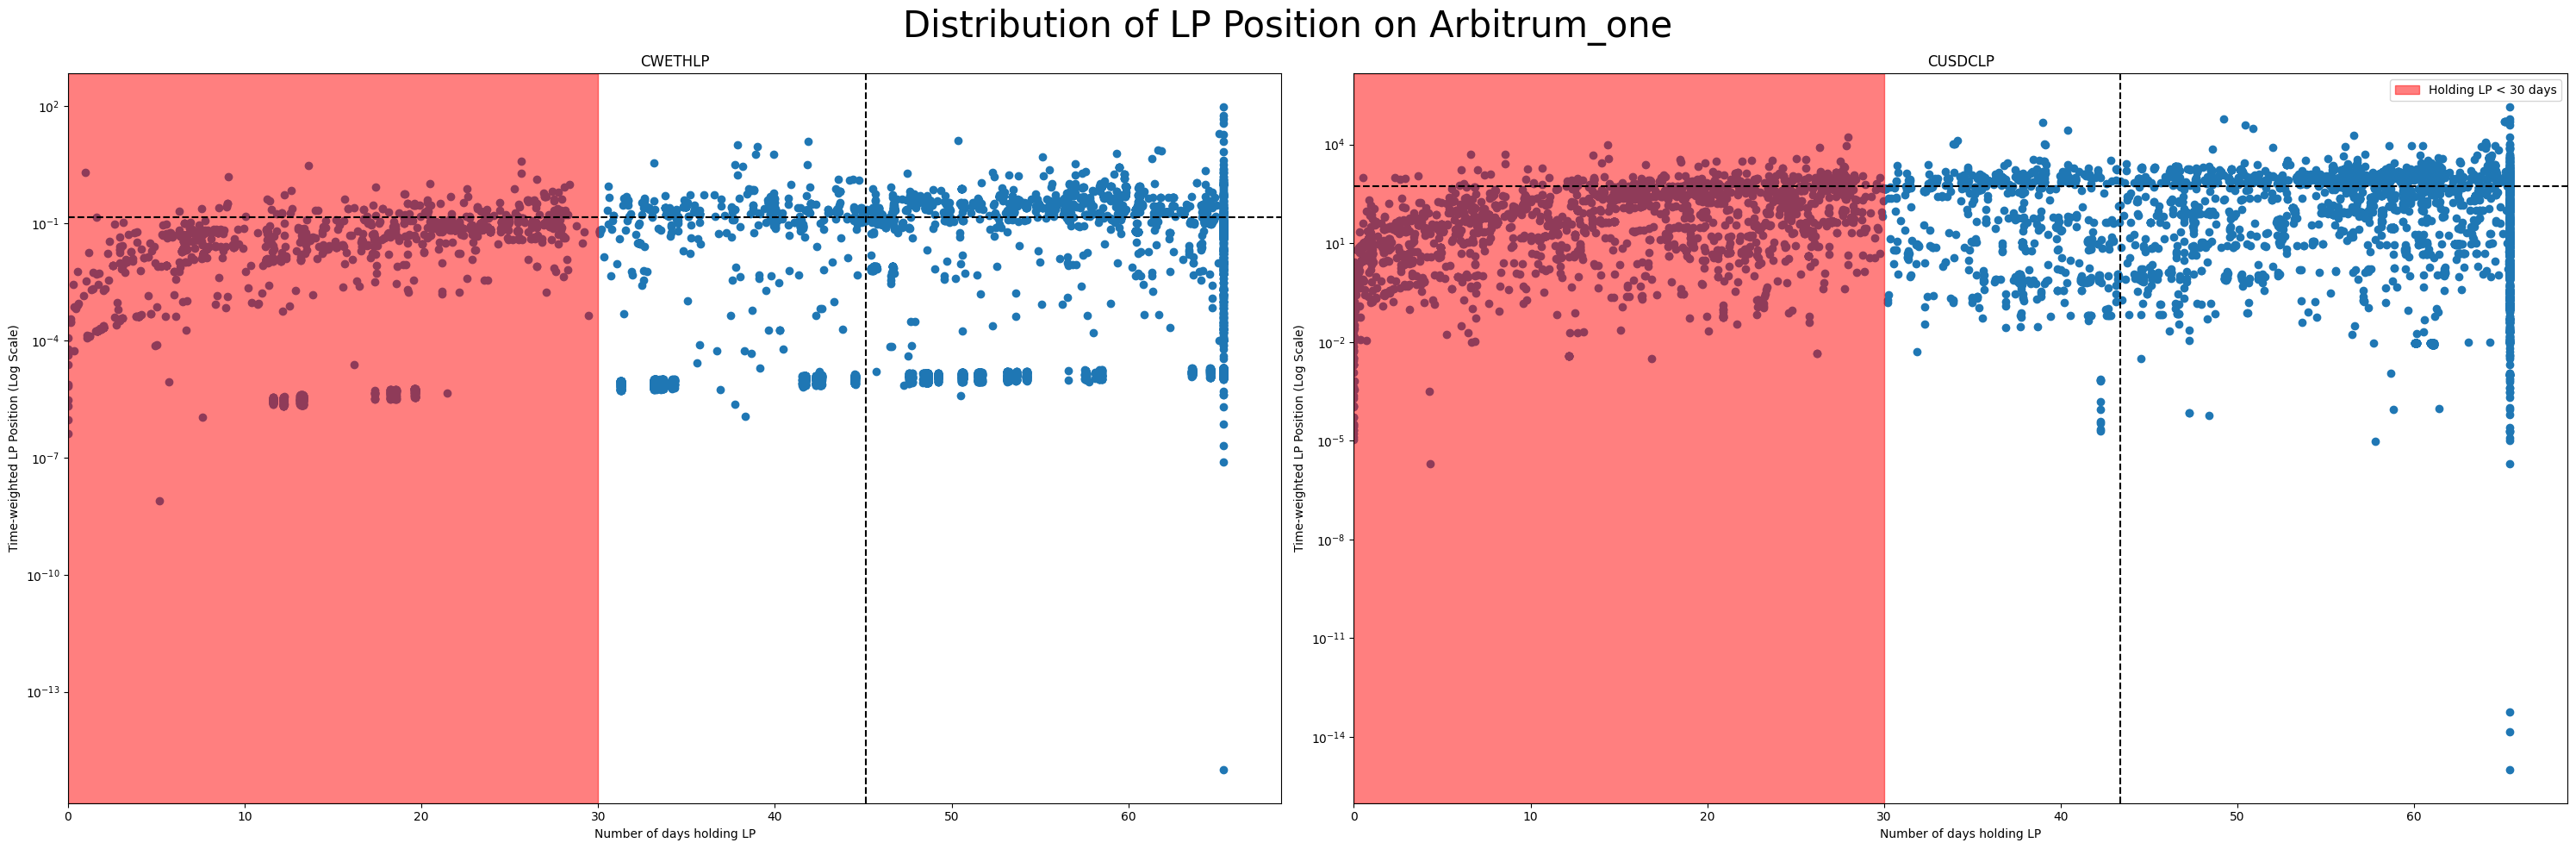

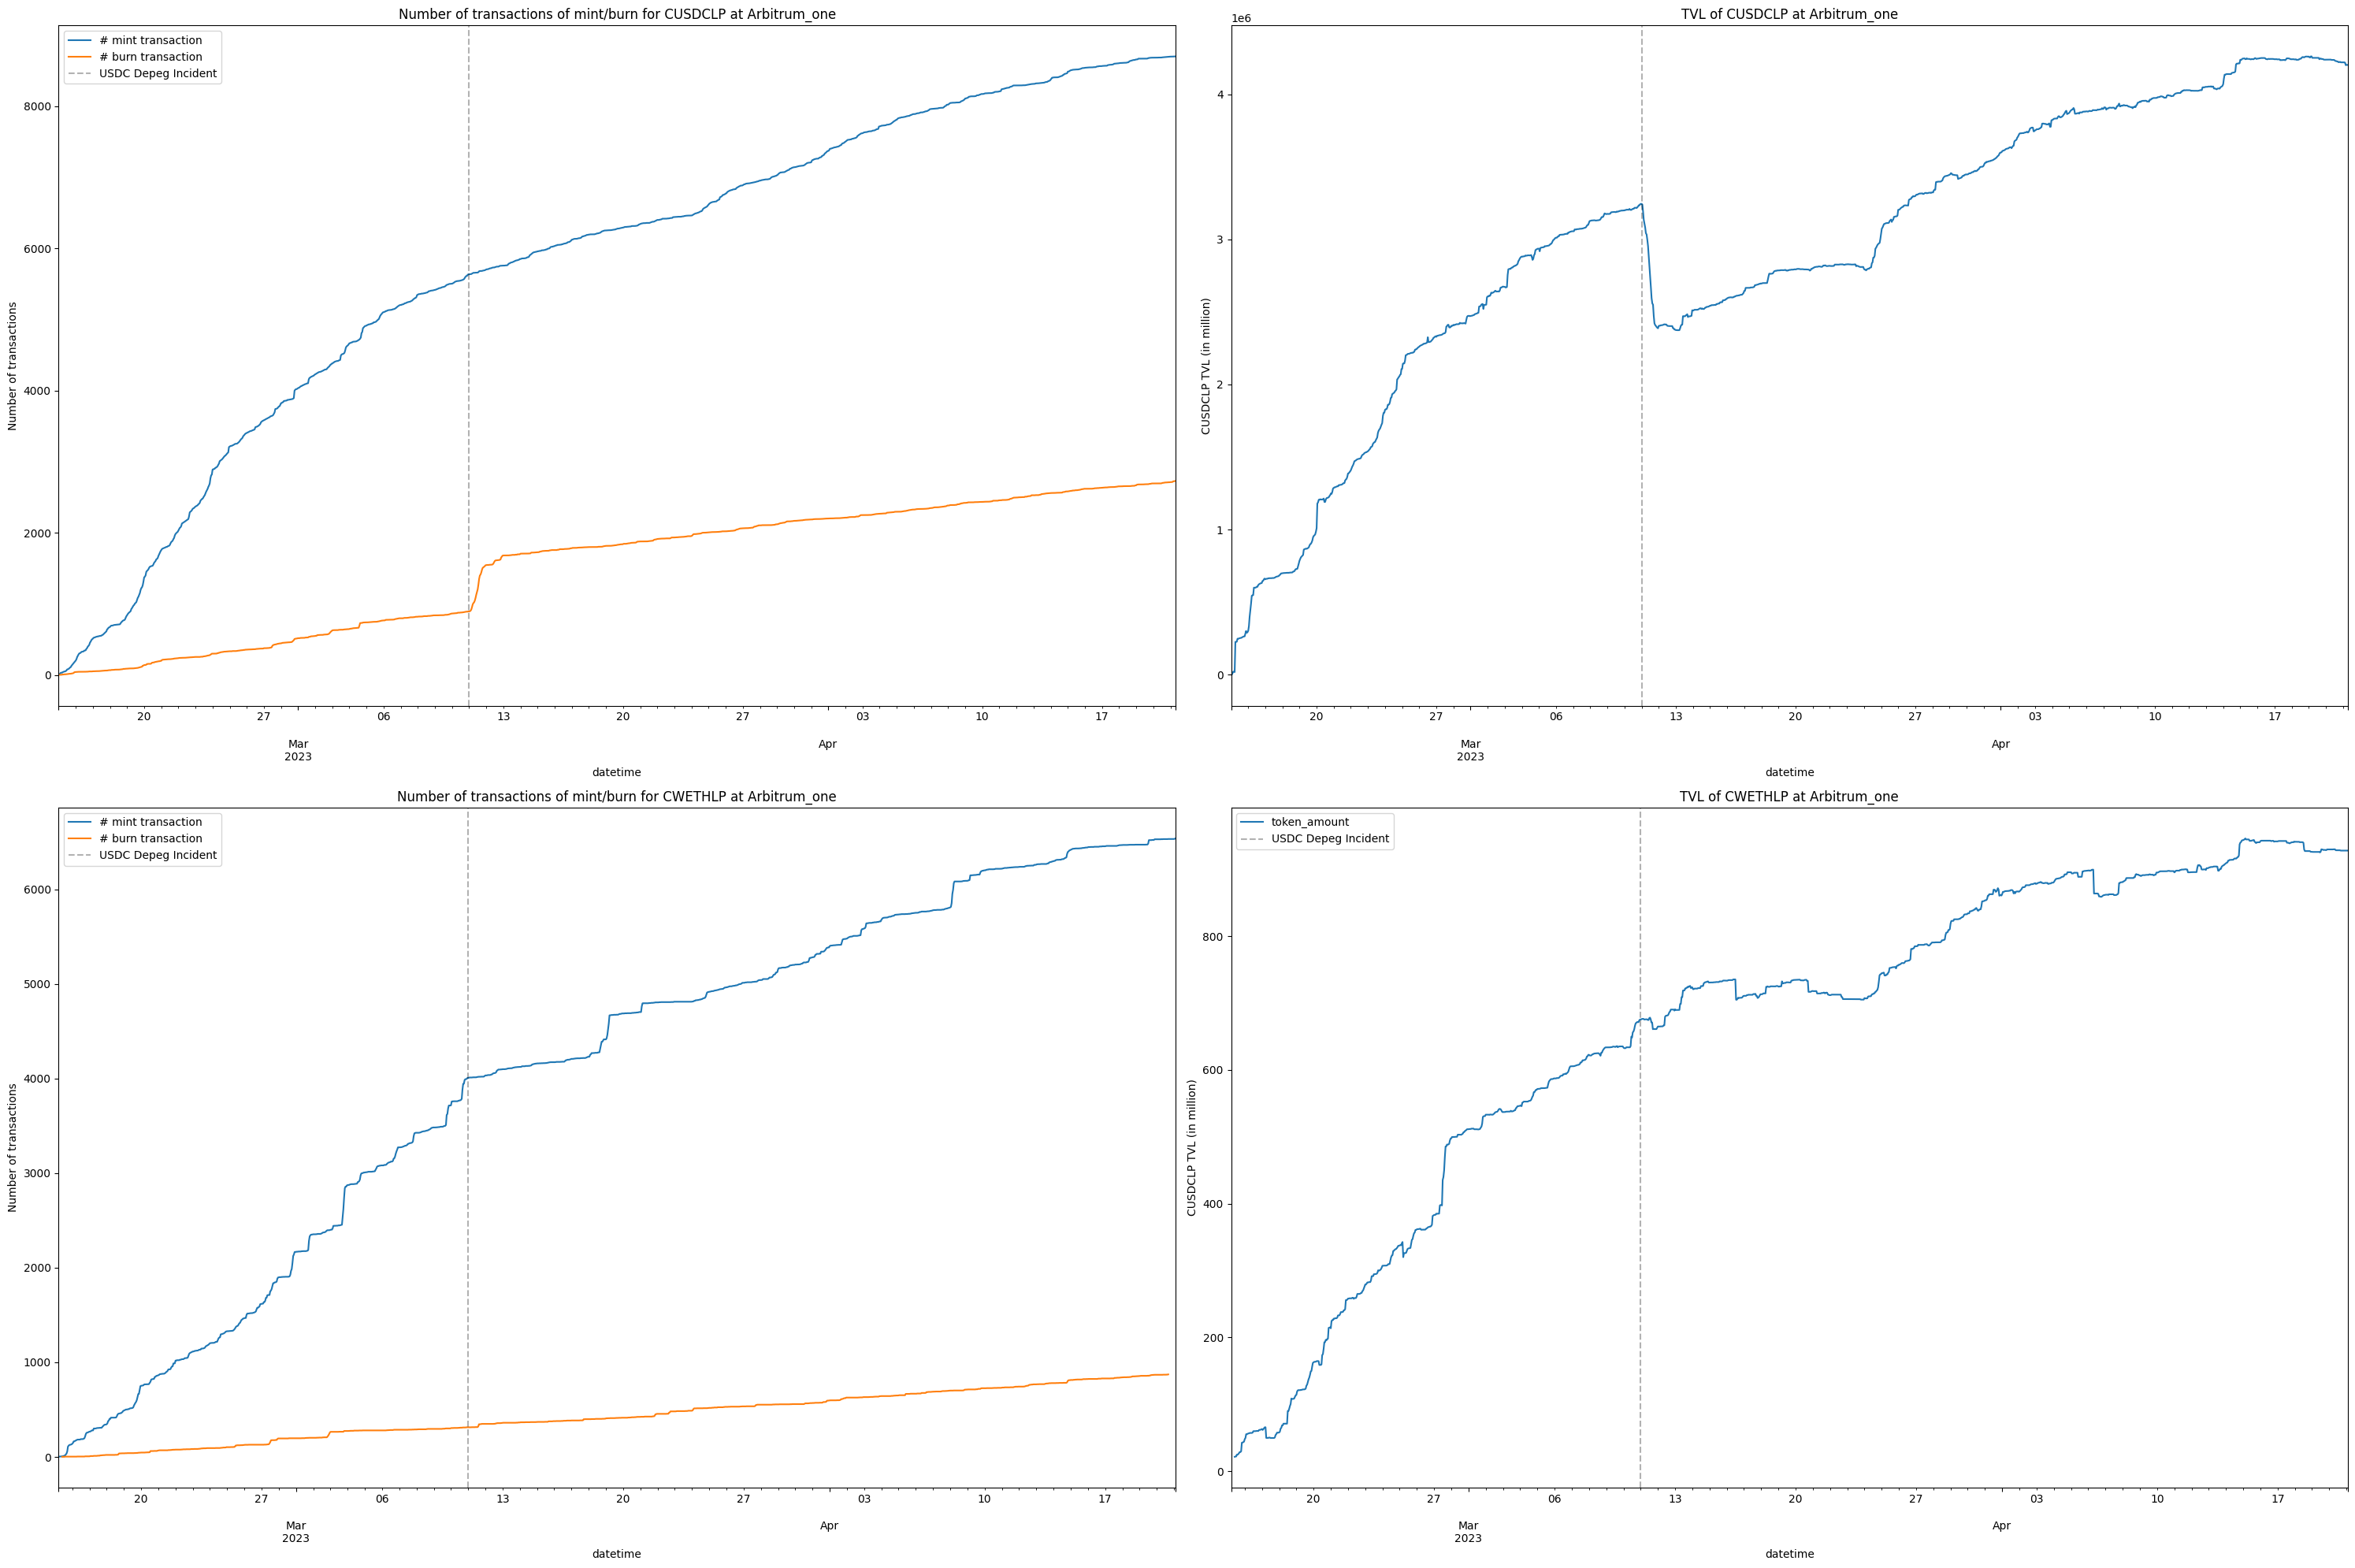

Number of users holding CWETHLP: 7659
Number of users holding CUSDCLP: 6659
Total of CWETHLP Add Liquidity tx: 8596
Total of CWETHLP Remove Liquidity tx: 937
Total of CUSDCLP Add Liquidity tx: 11154
Total of CUSDCLP Remove Liquidity tx: 3048
Number of qualified USDC LP Provider: 1998 / 6659
Minimum qualified score: 463.7739
Number of qualified WETH LP Provider: 2298 / 7659
Minimum qualified score: 0.0728

Optimism


Analyzing users in Optimism:   0%|          | 0/2728 [00:00<?, ?it/s]

Processing User info:   0%|          | 0/2728 [00:00<?, ?it/s]

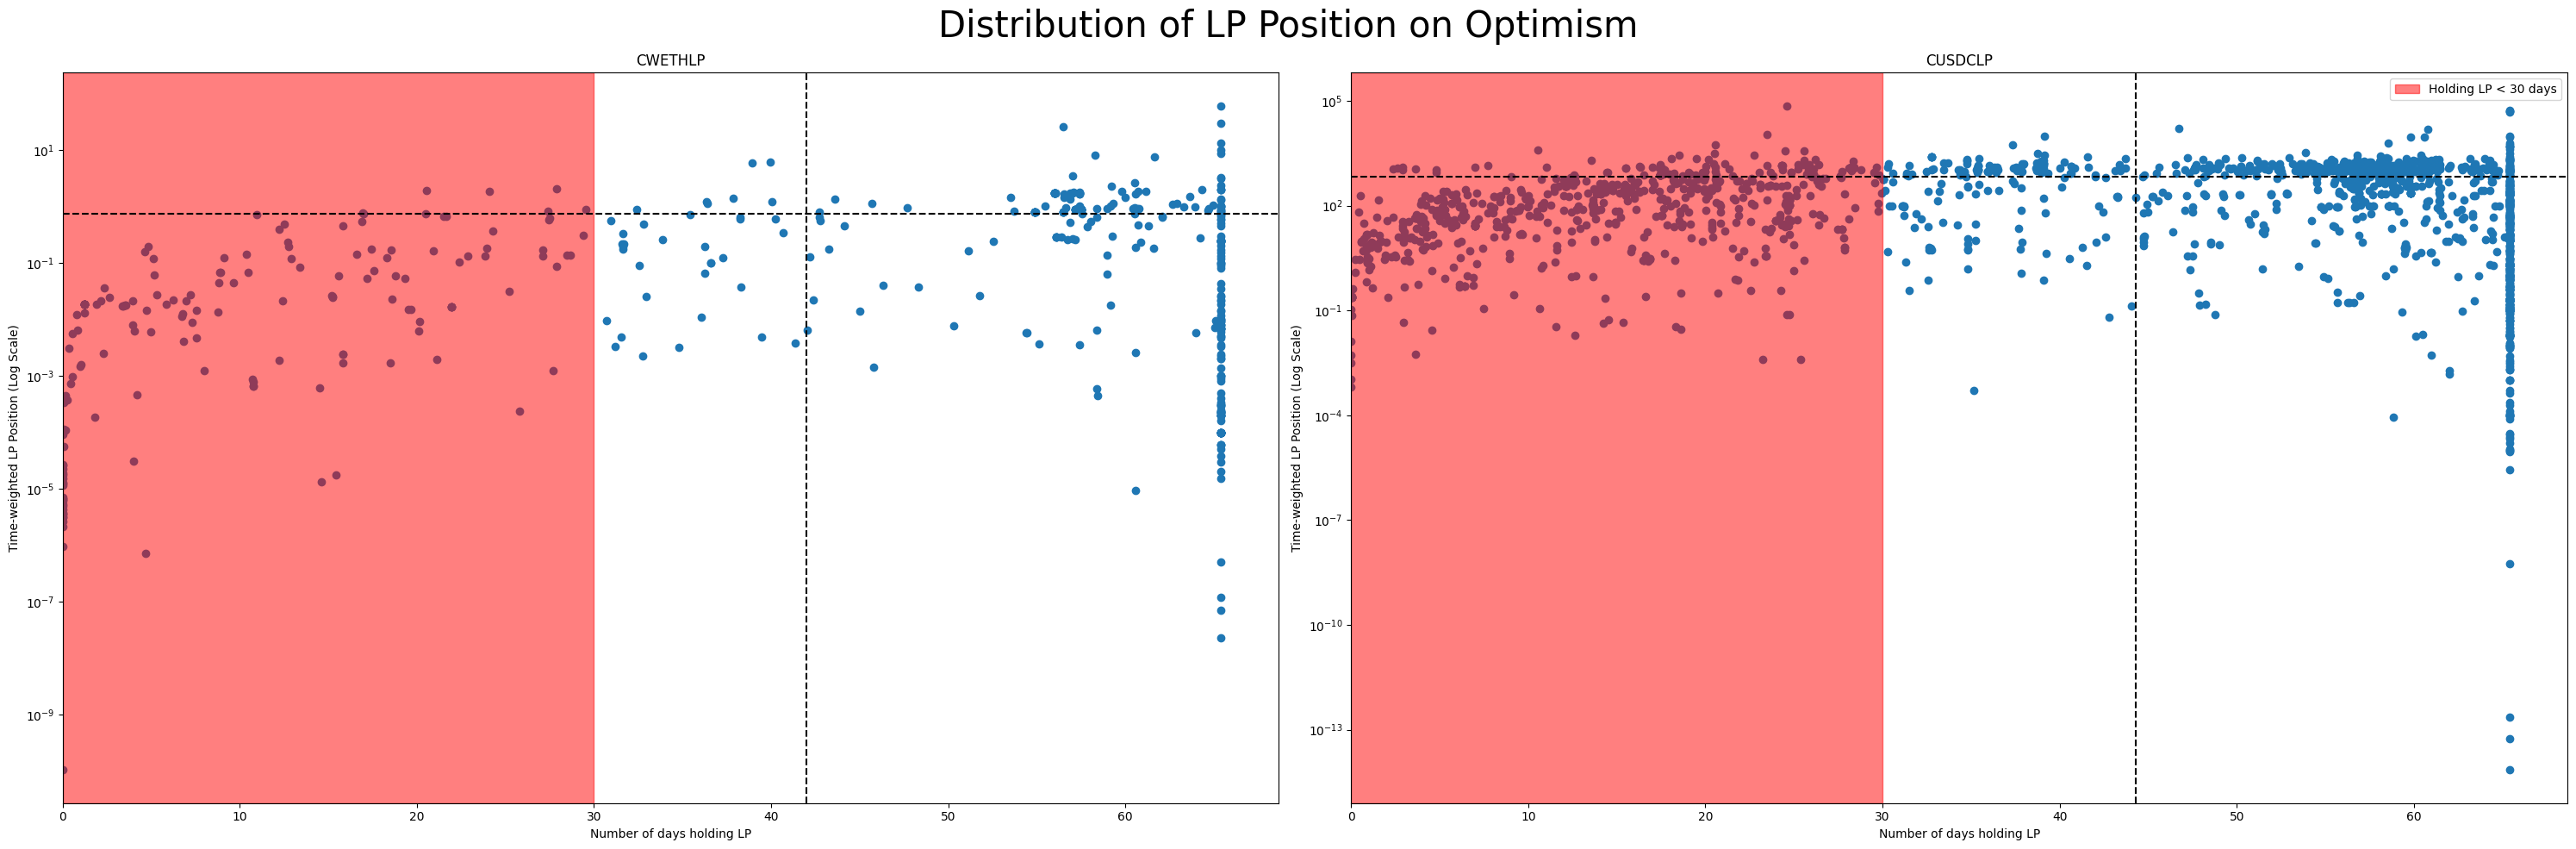

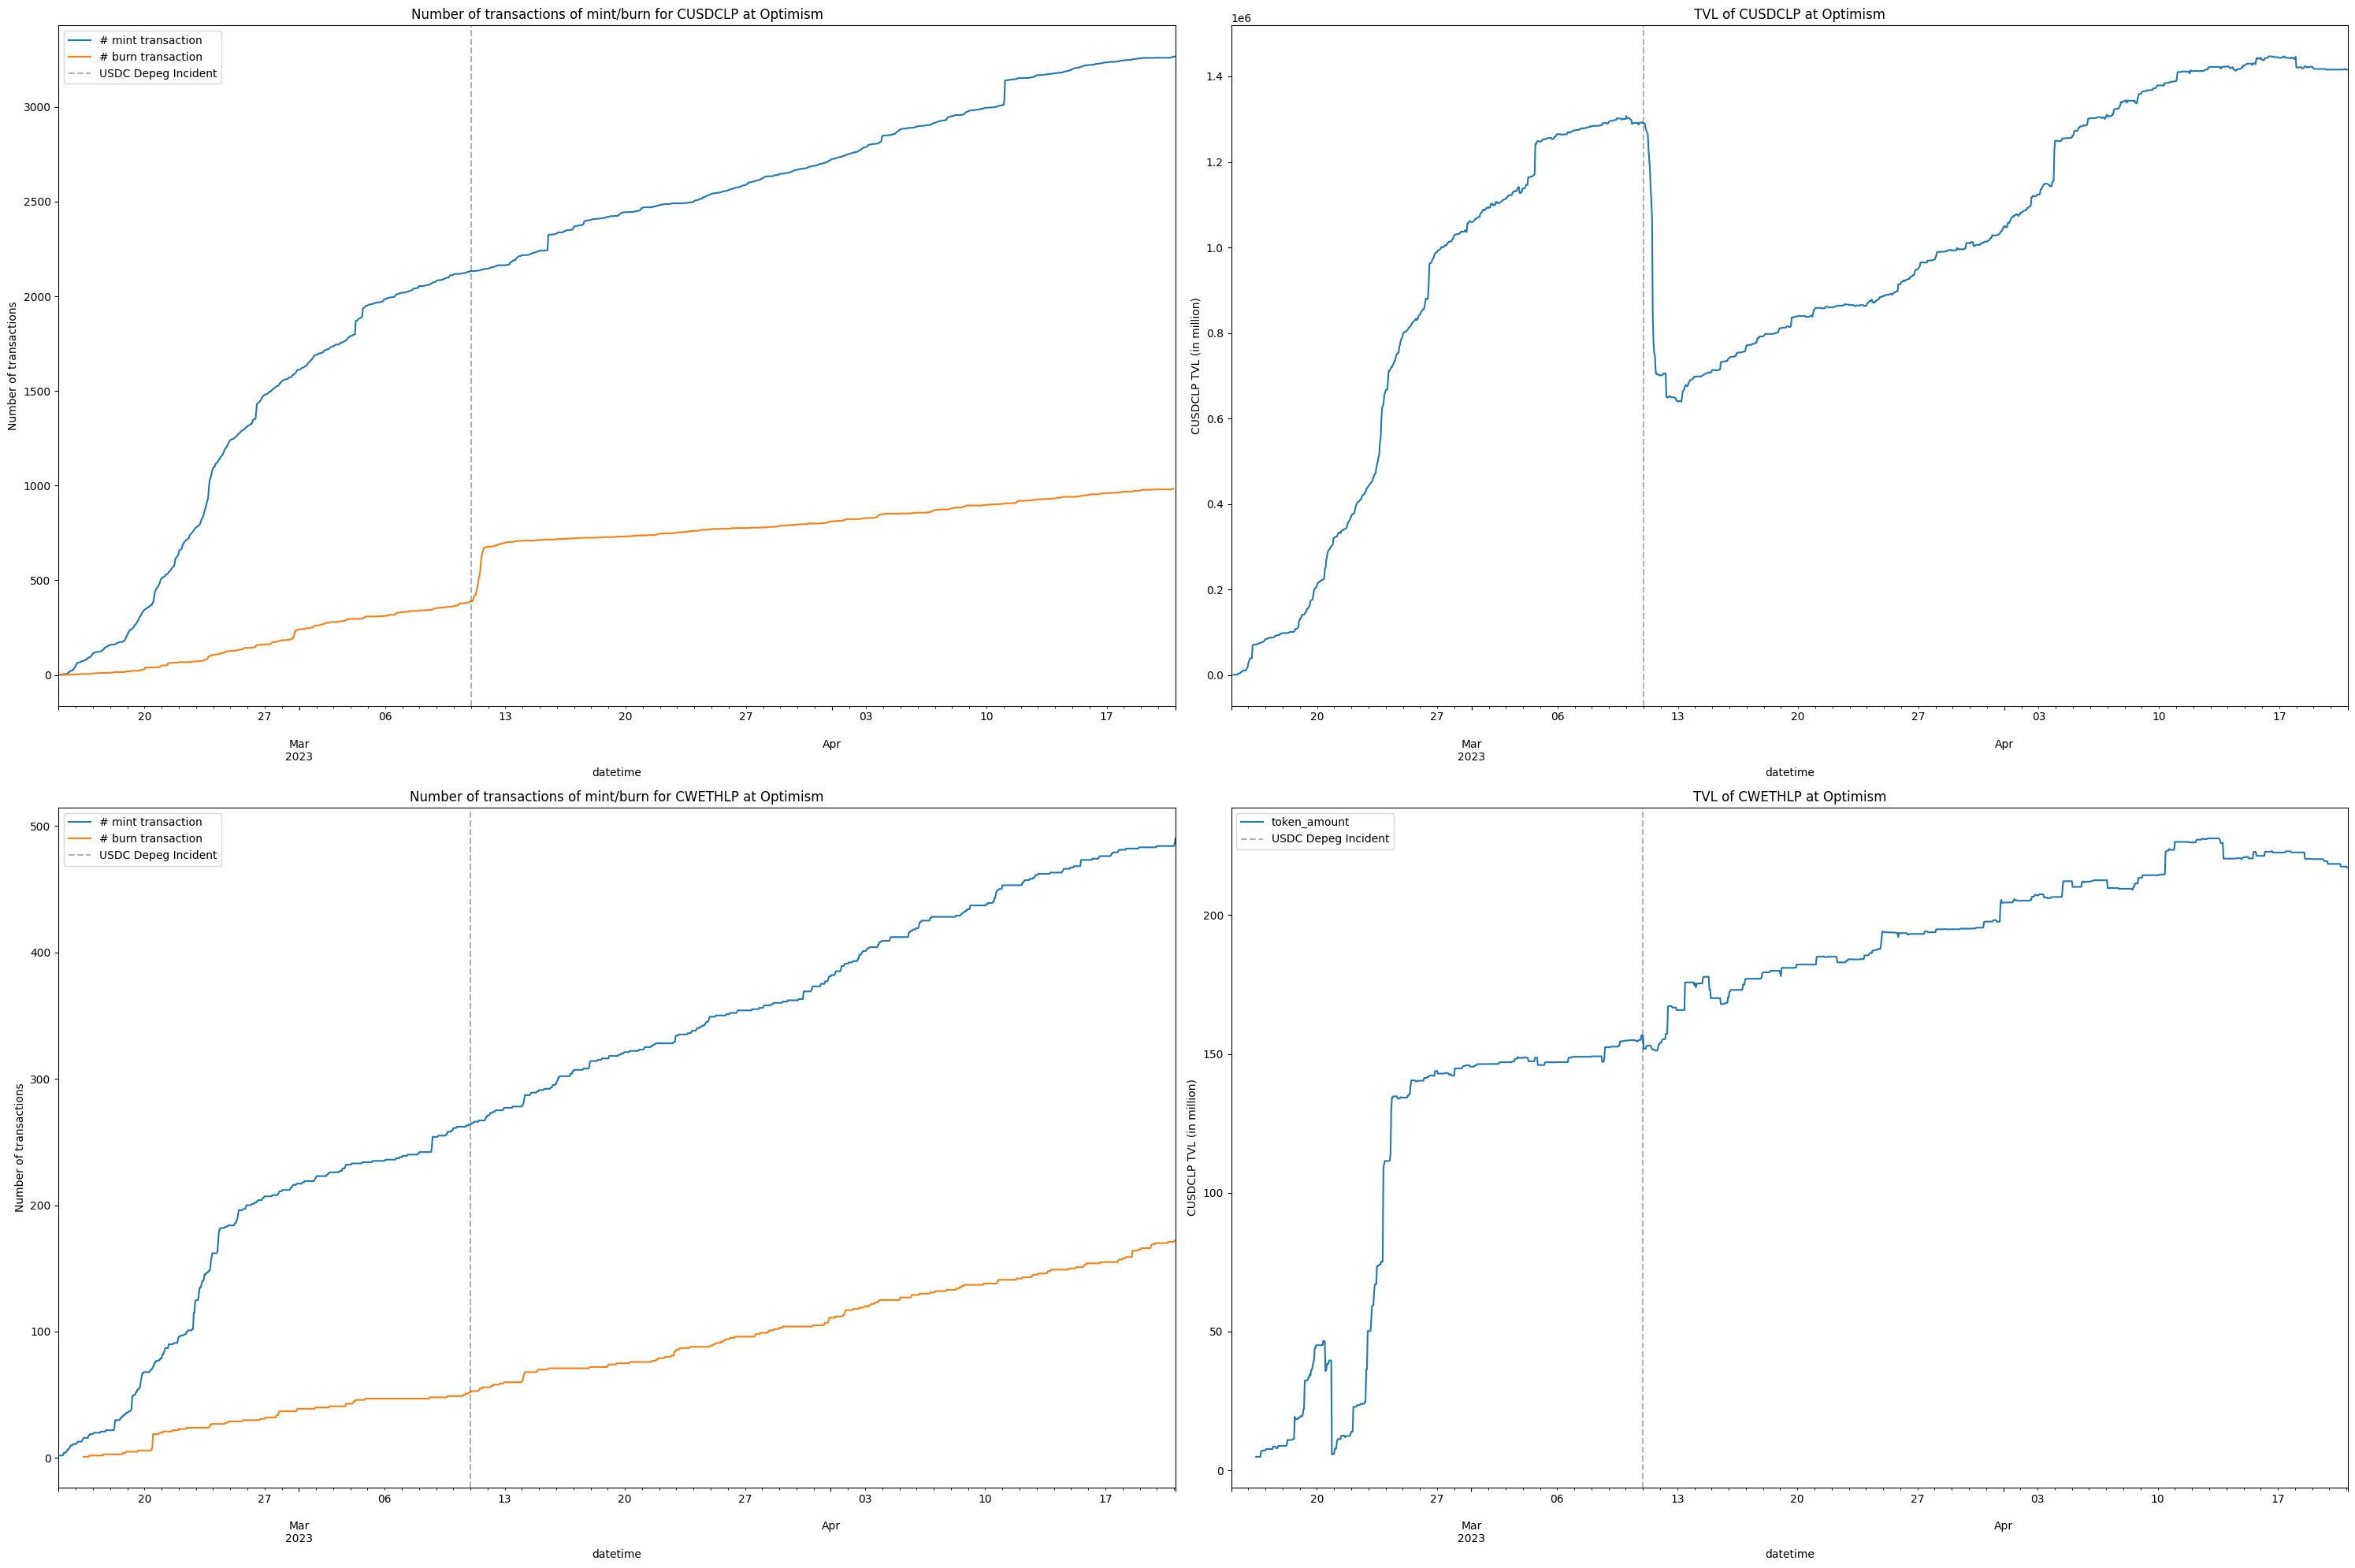

Number of users holding CWETHLP: 489
Number of users holding CUSDCLP: 2375
Total of CWETHLP Add Liquidity tx: 668
Total of CWETHLP Remove Liquidity tx: 189
Total of CUSDCLP Add Liquidity tx: 4157
Total of CUSDCLP Remove Liquidity tx: 1079
Number of qualified USDC LP Provider: 712 / 2375
Minimum qualified score: 815.6359
Number of qualified WETH LP Provider: 147 / 489
Minimum qualified score: 0.5981

Bnb_chain


Analyzing users in Bnb_chain:   0%|          | 0/1565 [00:00<?, ?it/s]

Processing User info:   0%|          | 0/1565 [00:00<?, ?it/s]

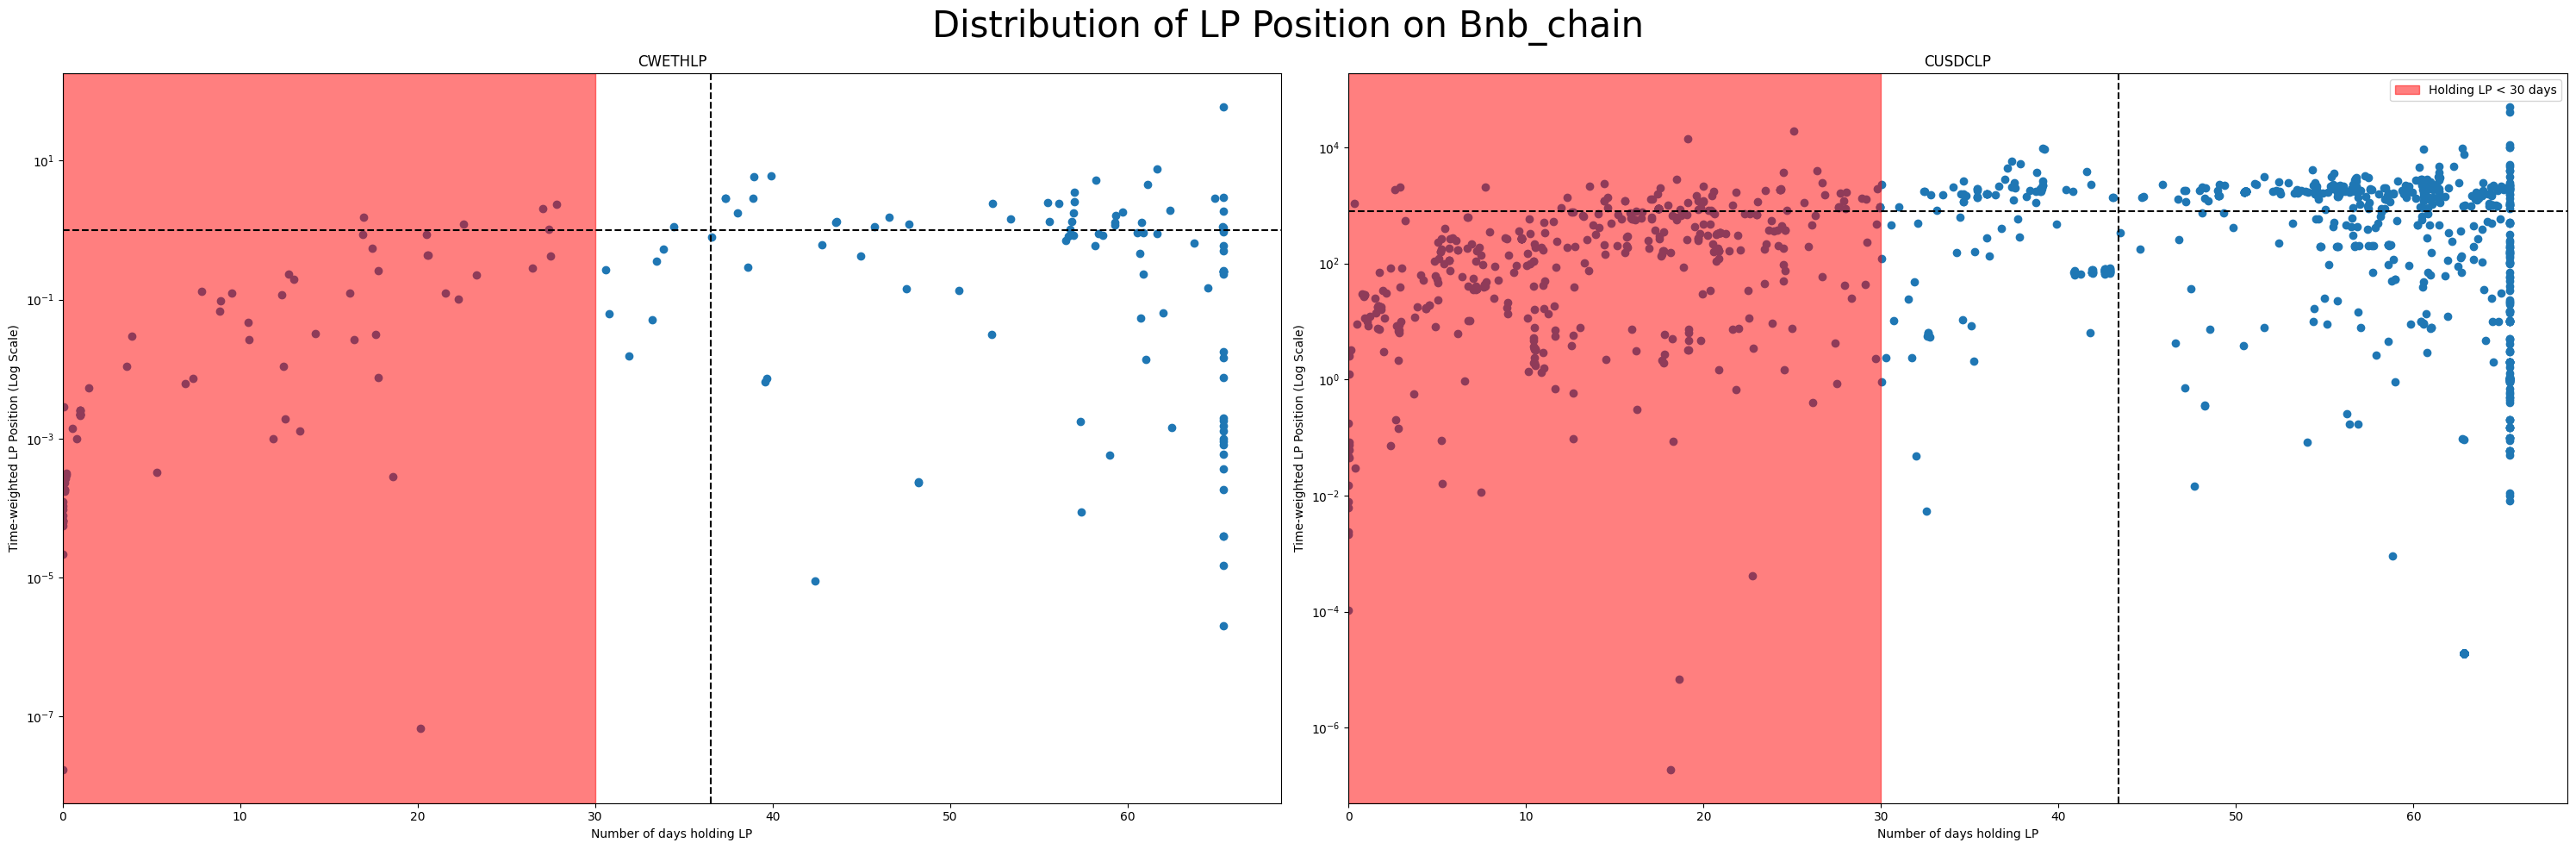

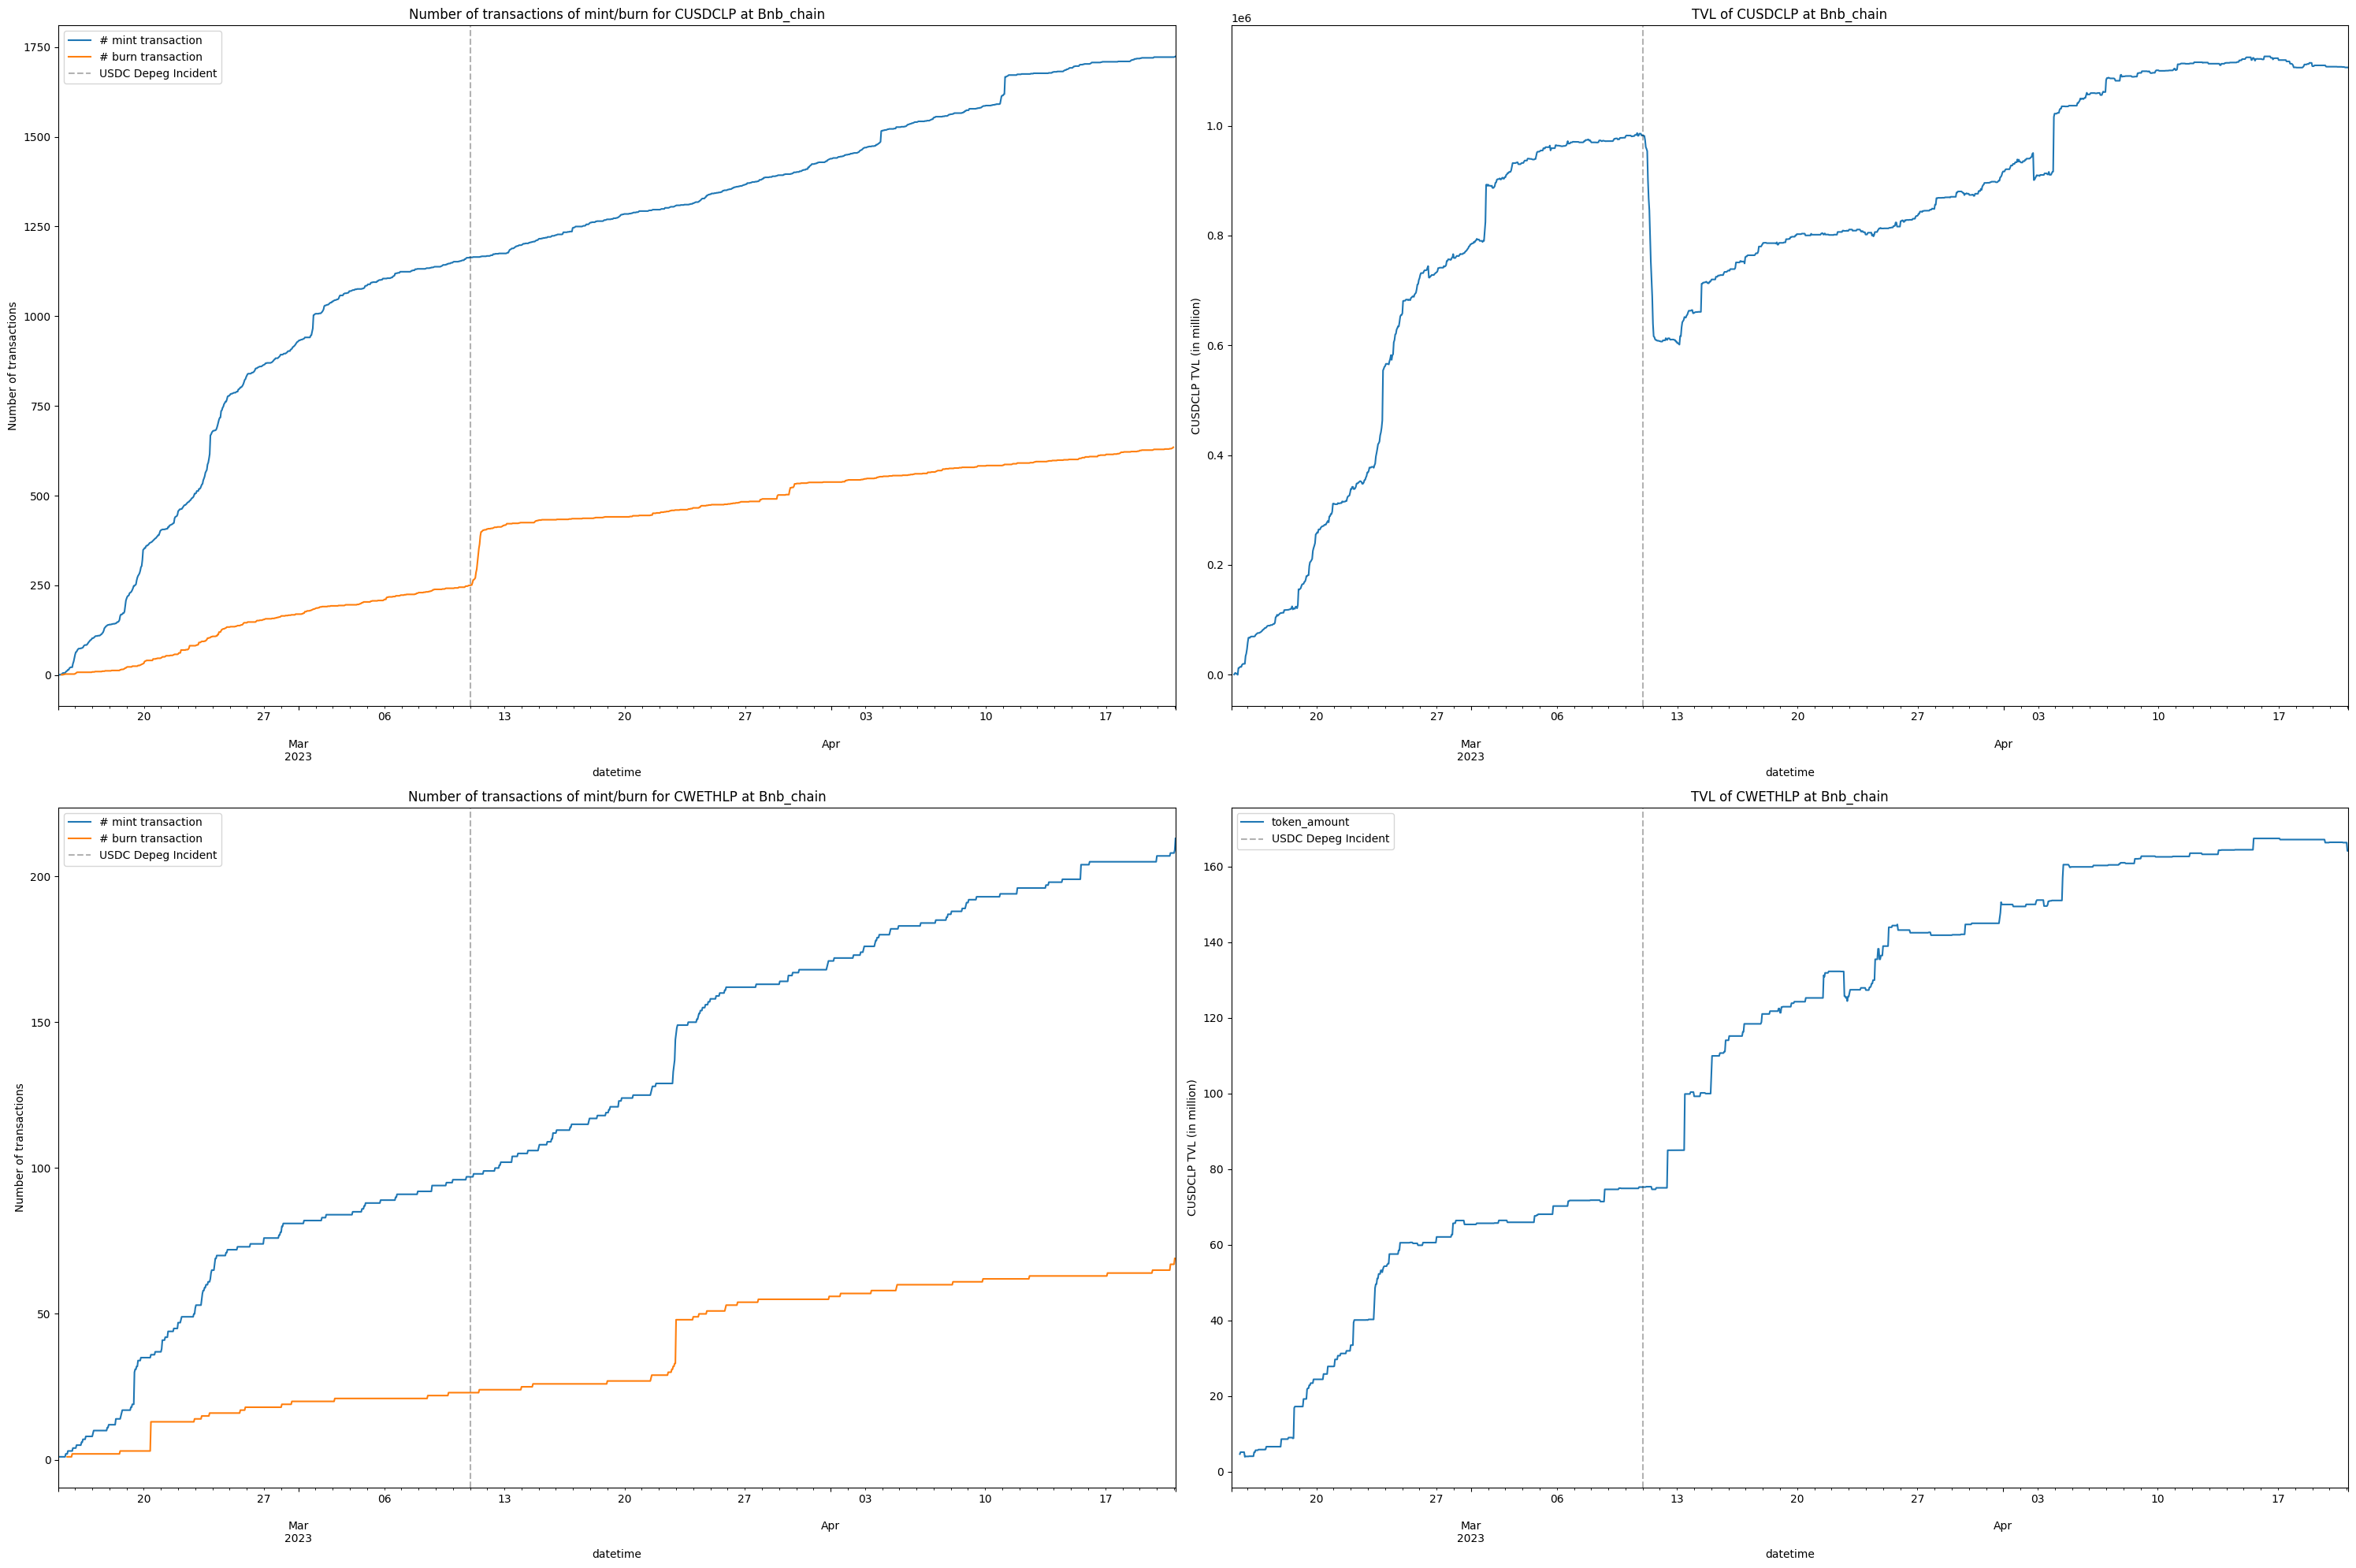

Number of users holding CWETHLP: 177
Number of users holding CUSDCLP: 1423
Total of CWETHLP Add Liquidity tx: 253
Total of CWETHLP Remove Liquidity tx: 72
Total of CUSDCLP Add Liquidity tx: 2078
Total of CUSDCLP Remove Liquidity tx: 685
Number of qualified USDC LP Provider: 427 / 1423
Minimum qualified score: 958.0677
Number of qualified WETH LP Provider: 53 / 177
Minimum qualified score: 0.8190

Polygon


Analyzing users in Polygon:   0%|          | 0/5774 [00:00<?, ?it/s]

Processing User info:   0%|          | 0/5774 [00:00<?, ?it/s]

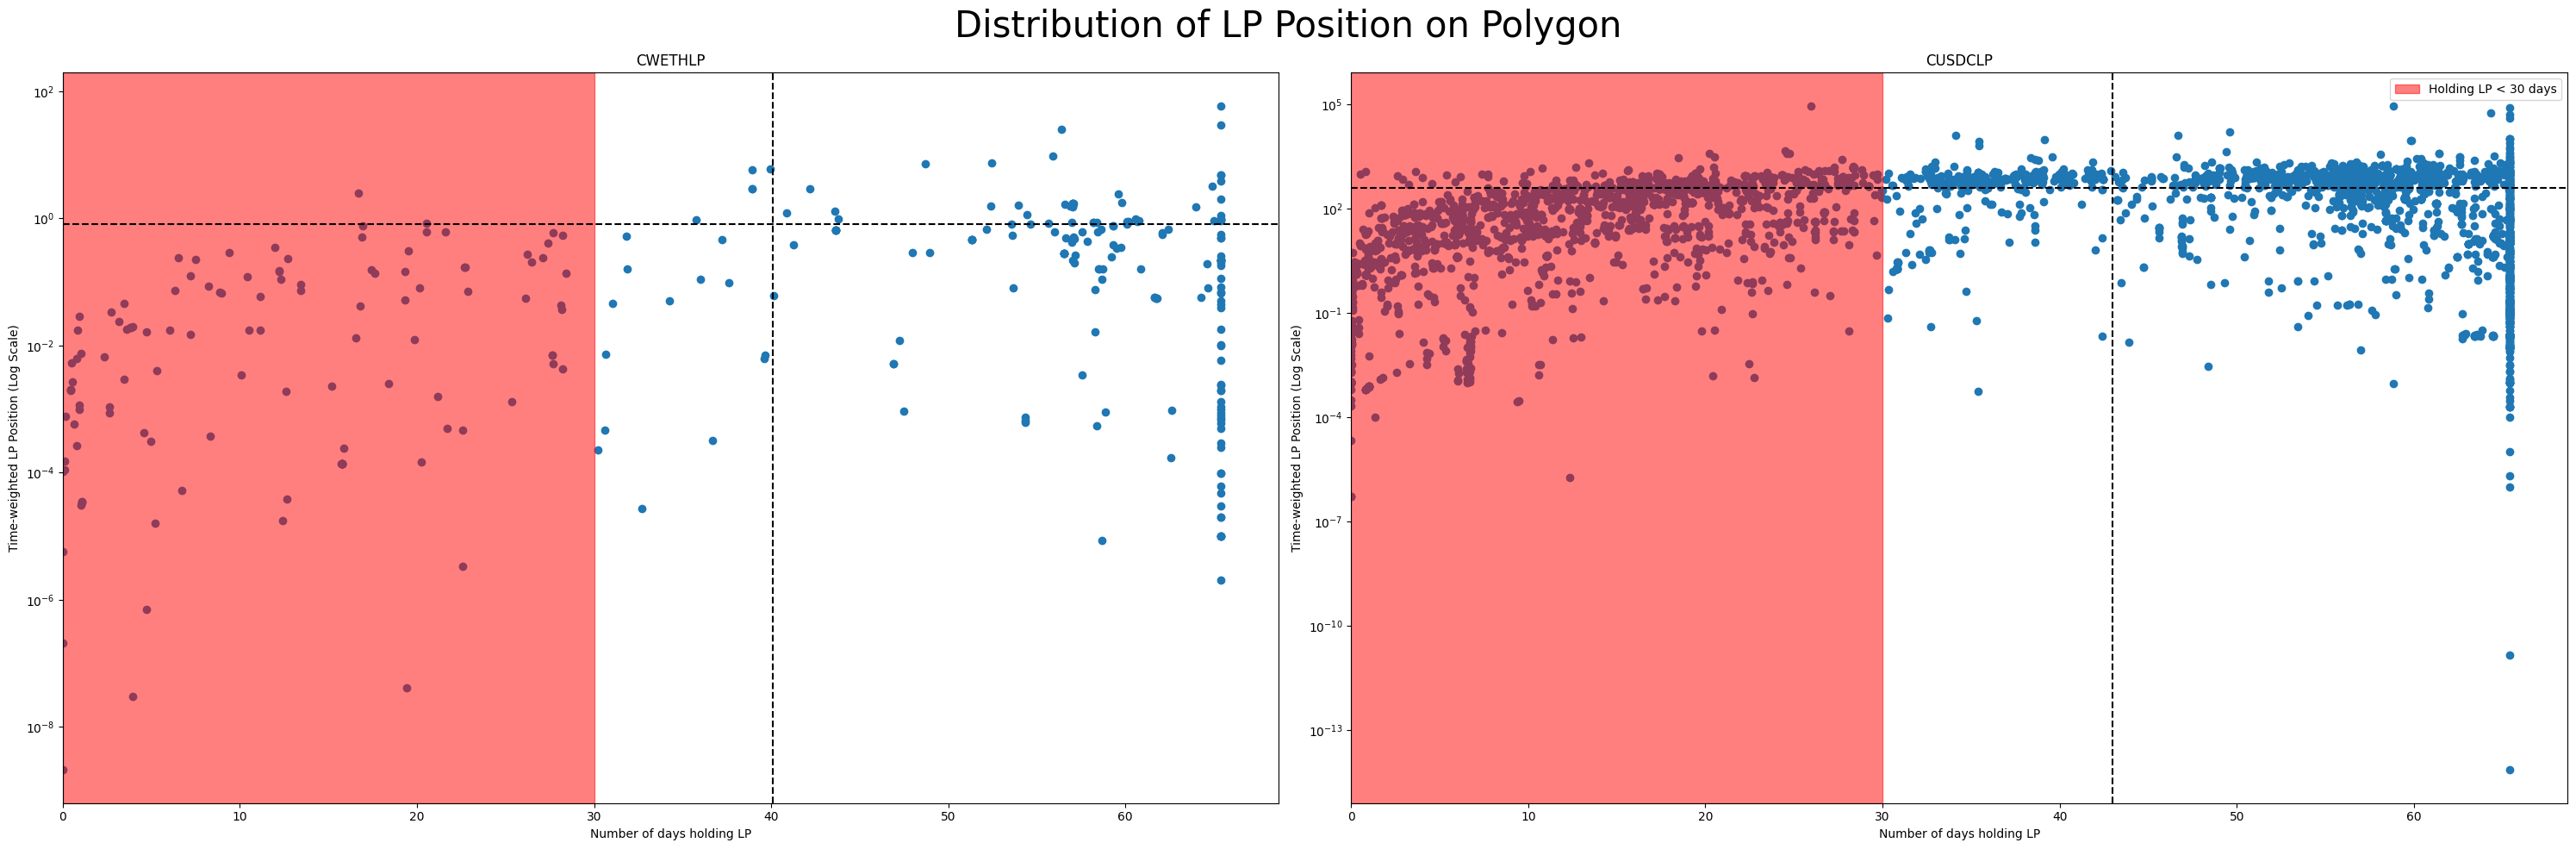

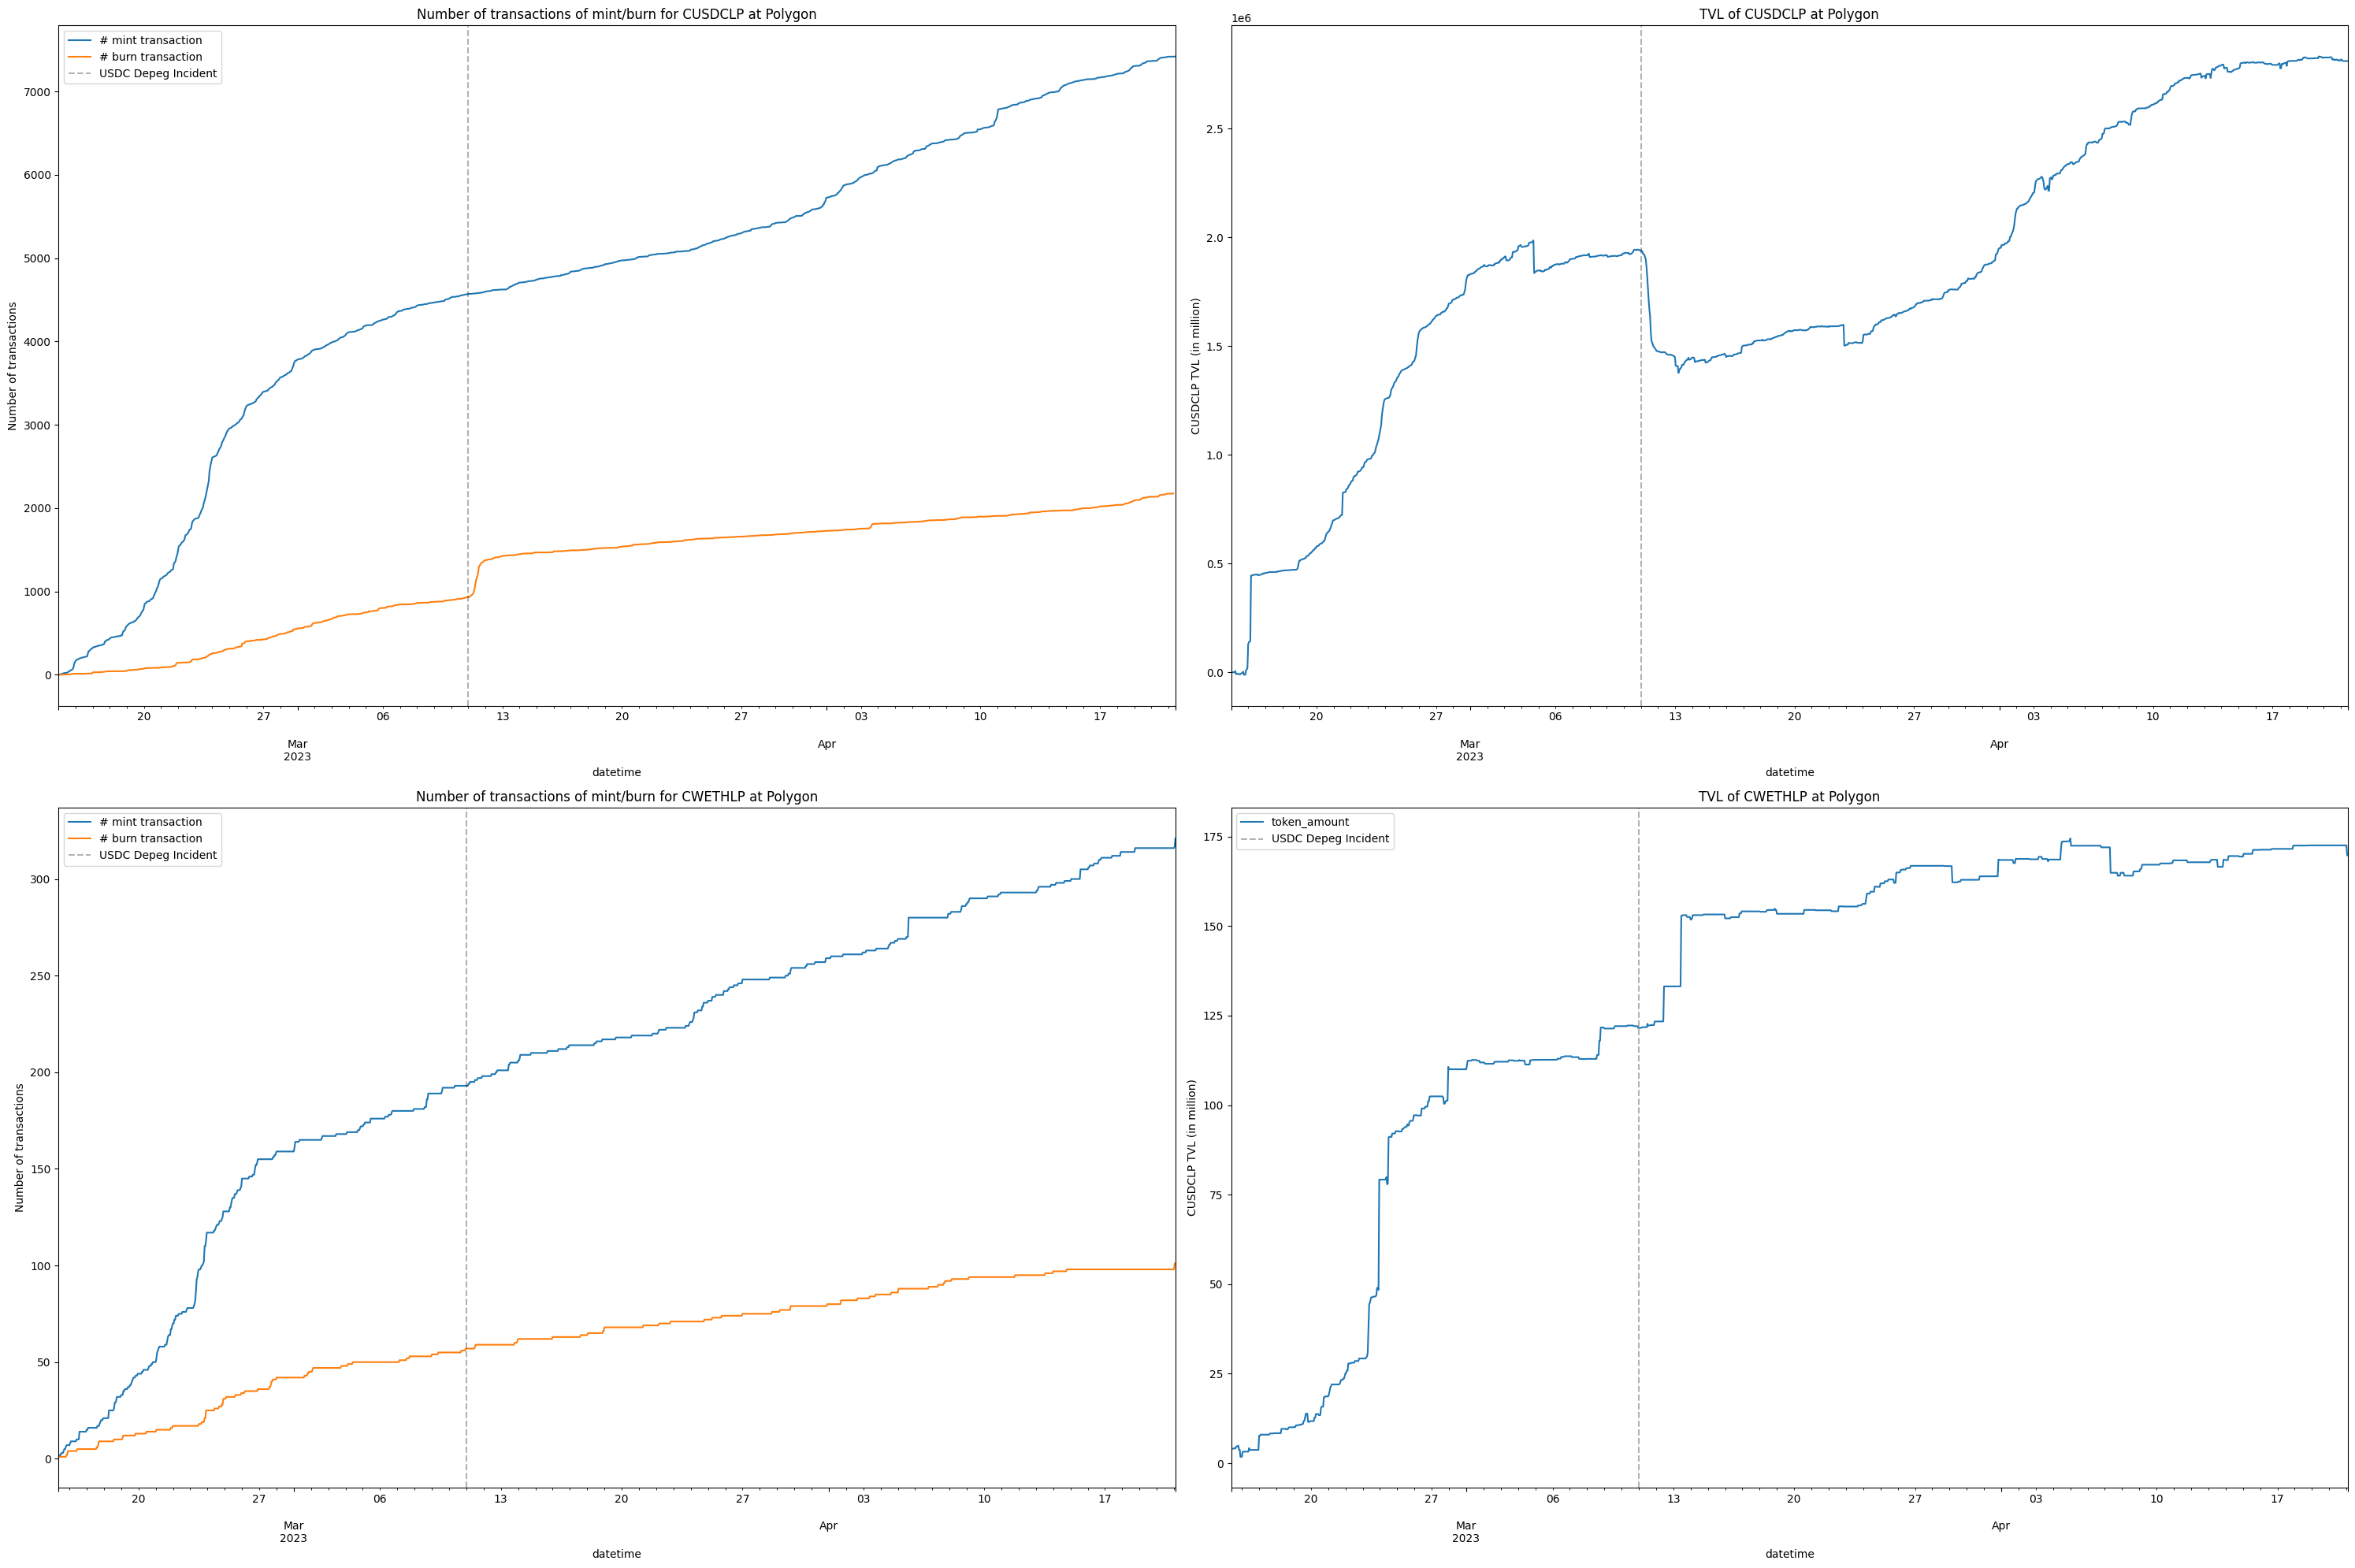

Number of users holding CWETHLP: 318
Number of users holding CUSDCLP: 5553
Total of CWETHLP Add Liquidity tx: 411
Total of CWETHLP Remove Liquidity tx: 111
Total of CUSDCLP Add Liquidity tx: 10466
Total of CUSDCLP Remove Liquidity tx: 2298
Number of qualified USDC LP Provider: 1666 / 5553
Minimum qualified score: 445.9168
Number of qualified WETH LP Provider: 95 / 318
Minimum qualified score: 0.3525

Gnosis


Analyzing users in Gnosis:   0%|          | 0/1281 [00:00<?, ?it/s]

Processing User info:   0%|          | 0/1281 [00:00<?, ?it/s]

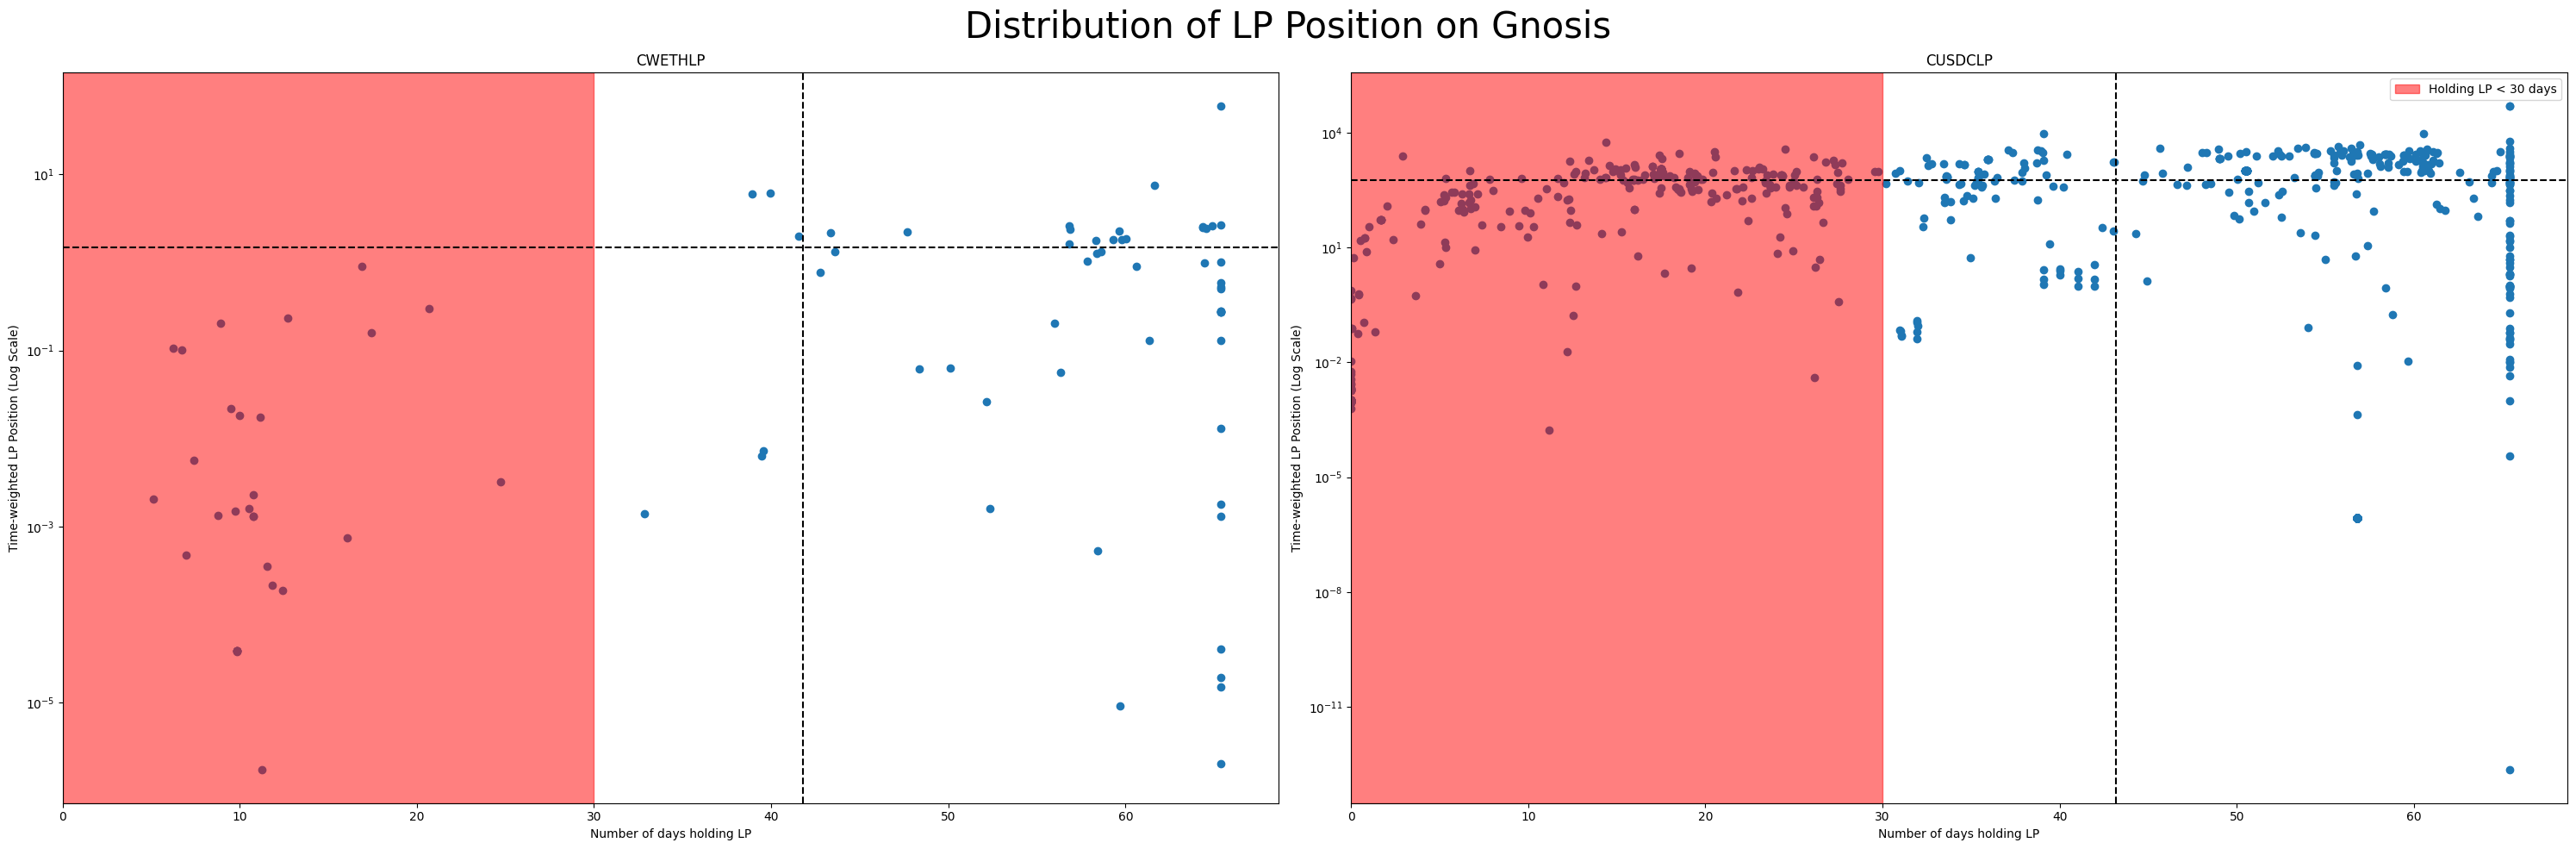

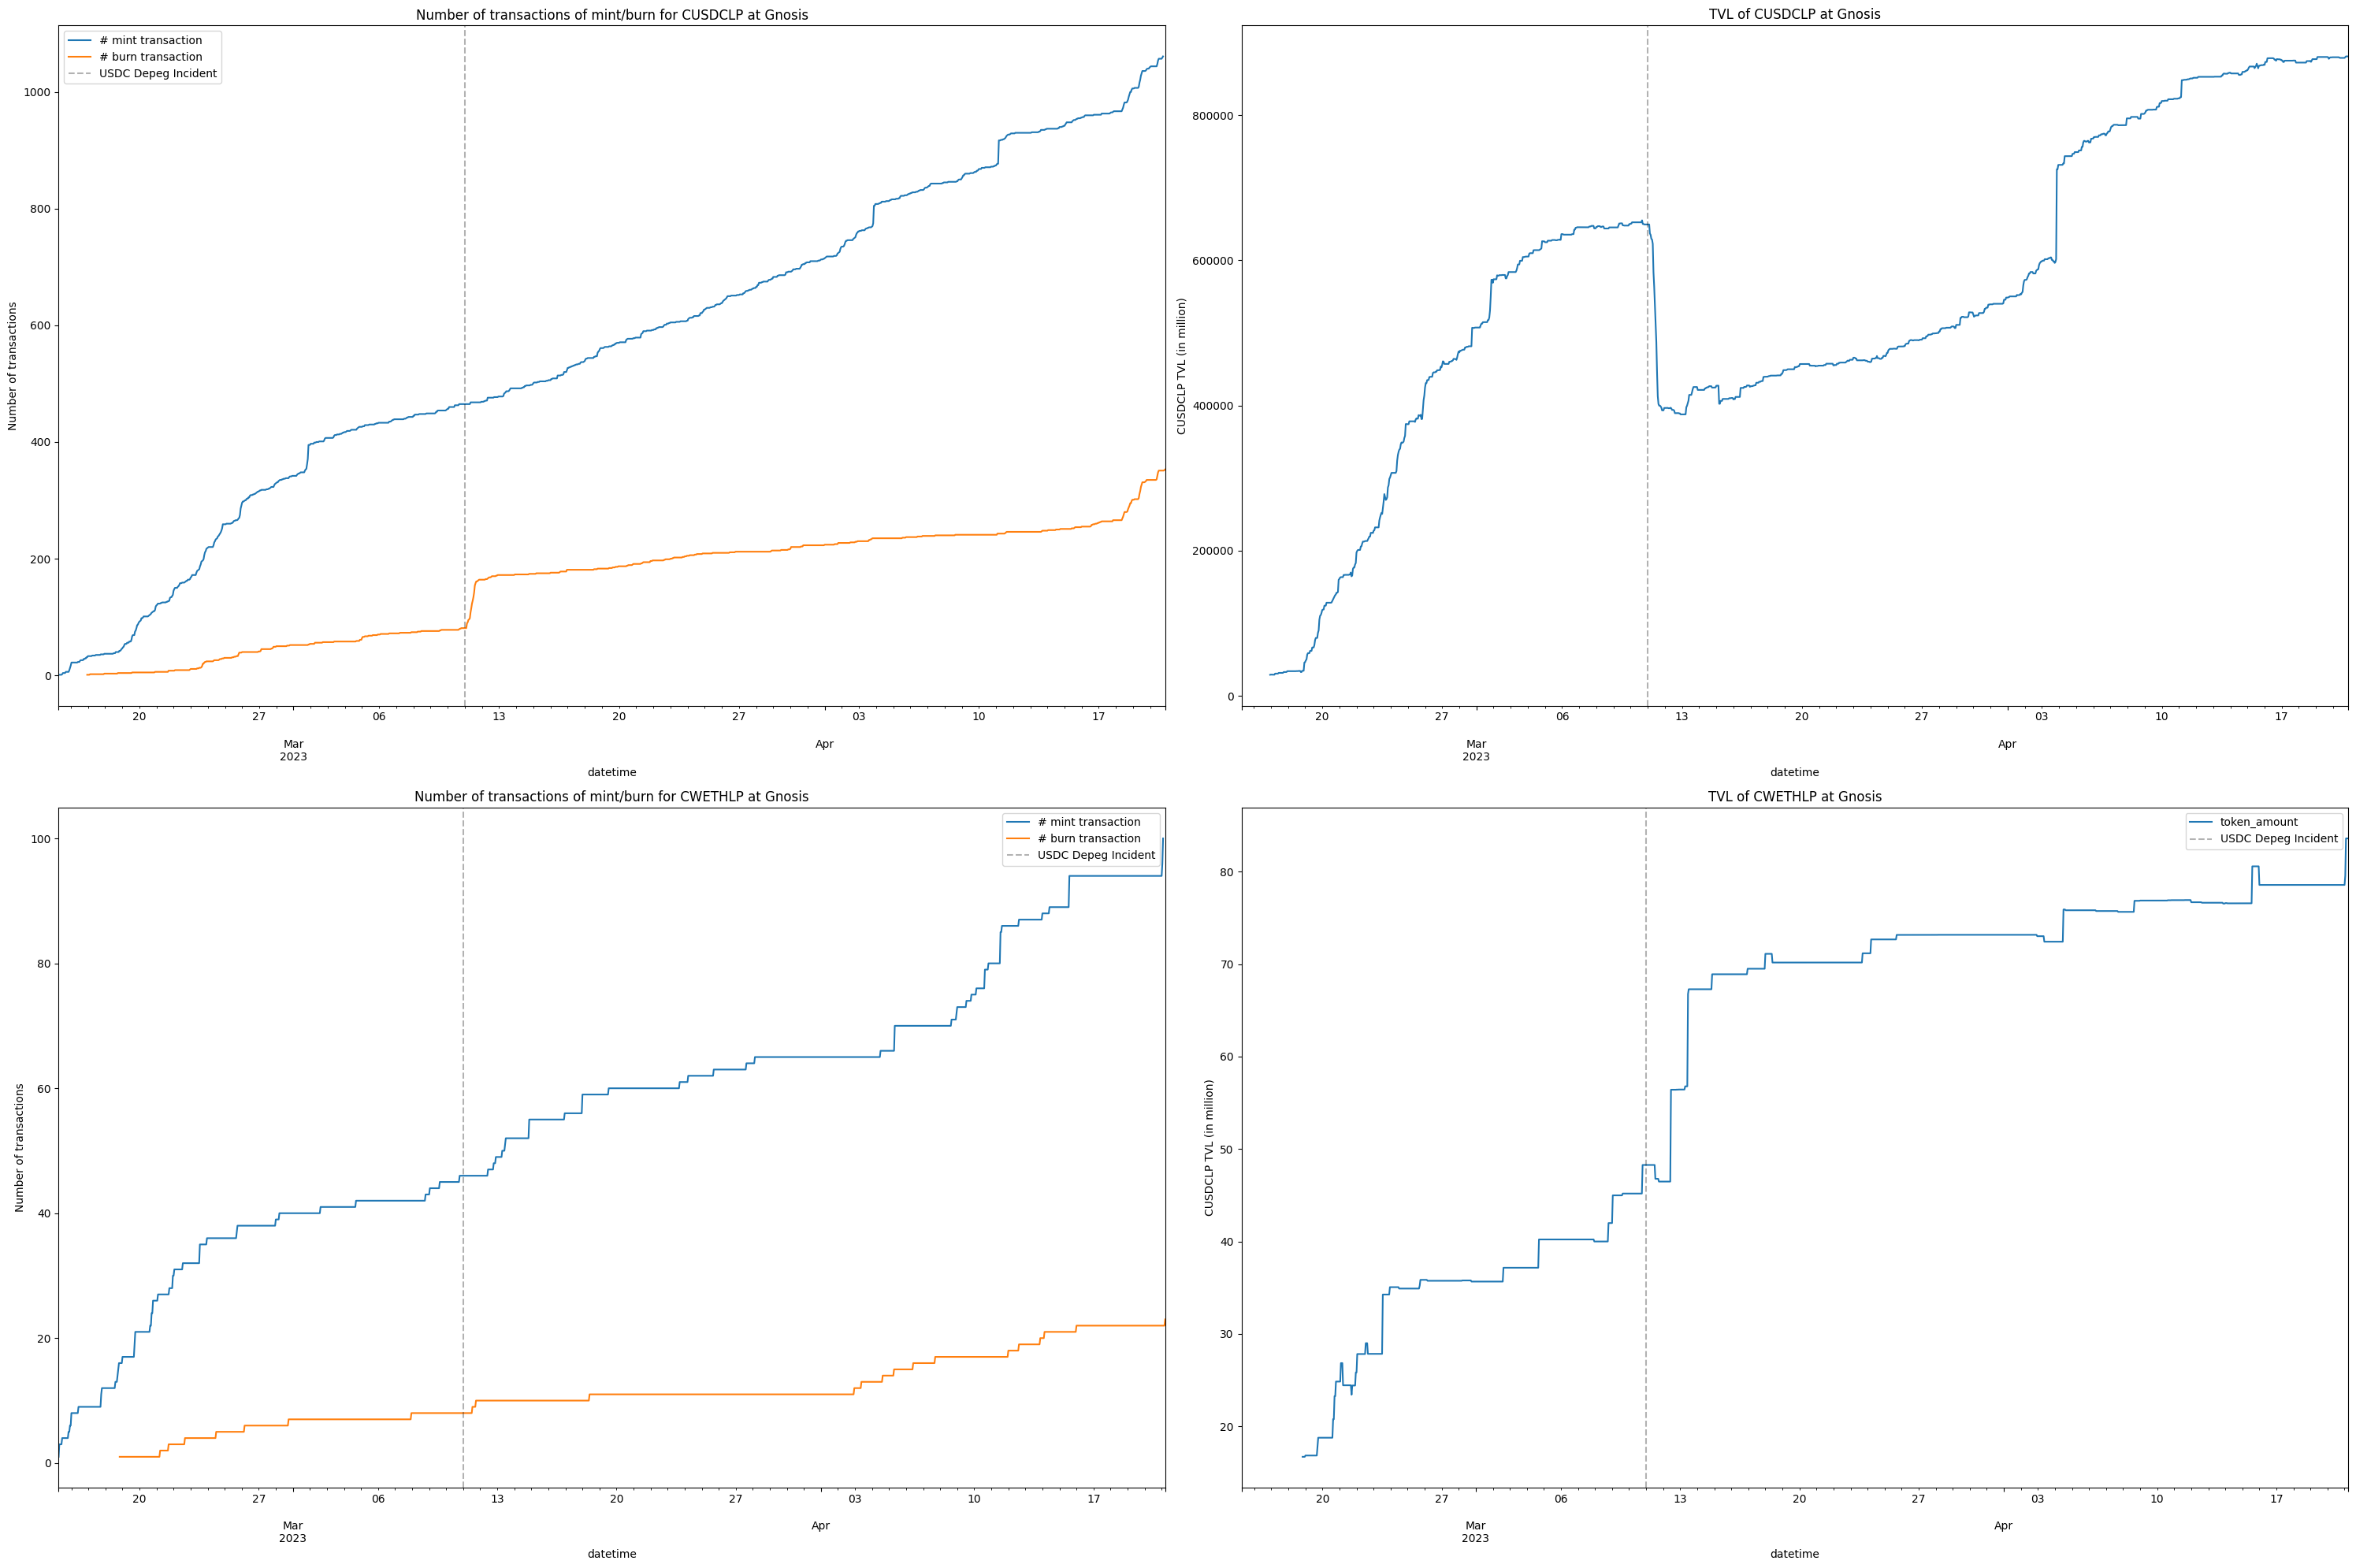

Number of users holding CWETHLP: 87
Number of users holding CUSDCLP: 1222
Total of CWETHLP Add Liquidity tx: 131
Total of CWETHLP Remove Liquidity tx: 27
Total of CUSDCLP Add Liquidity tx: 1174
Total of CUSDCLP Remove Liquidity tx: 368
Number of qualified USDC LP Provider: 367 / 1222
Minimum qualified score: 498.6343
Number of qualified WETH LP Provider: 26 / 87
Minimum qualified score: 0.9825



In [8]:
for chain in CHAINS:
    
    print(f"="*20)
    print(f"{Chain.resolve_connext_domain(chain).capitalize()}")
    print(f"="*20)

    # calculate statistics
    user_txs = ProcessingUtils.get_user_txs(
        dataset=dataset,
        chain=chain,
        latest_date=LATEST_DATE,
    )

    user_infos = {
        _user: {
            _token: ProcessingUtils.process_user_balance(
                user_tx=user_txs[_user][_token],
                latest_date=LATEST_DATE,
                timeframe=TIMEFRAME,
                min_lp_value=MIN_VALUE,
            ) for _token in LP_TOKENS
            if _token in user_txs[_user]
        } for _user in tqdm(user_txs, "Processing User info")
    }

    # visualization
    fig, ax = plt.subplots(1, 2, figsize=(30, 10))

    for i, token in enumerate(LP_TOKENS):
        elapsed_days = [_user[token]["elapsed_days"] for _user in user_infos.values() if token in _user]
        twa_balance = [_user[token]["twa_balance"] for _user in user_infos.values() if token in _user]

        ax[i].scatter(elapsed_days, twa_balance)
        ax[i].axvline(np.mean(elapsed_days), linestyle="--", color="black")
        ax[i].axhline(np.mean(twa_balance), linestyle="--", color="black")
        ax[i].set_yscale("log")

        ax[i].axvspan(0, 30, alpha=0.5, color='red', label="Holding LP < 30 days")
        ax[i].set_xlim(left=0)
        ax[i].set_xlabel("Number of days holding LP")
        ax[i].set_ylabel("Time-weighted LP Position (Log Scale)")
        ax[i].set_title(f"{token}")

    fig.suptitle(f"Distribution of LP Position on {Chain.resolve_connext_domain(chain).capitalize()}", fontsize=30)
    plt.legend()
    plt.tight_layout()
    plt.show()

    VisualizeUtils.visualize_lps(dataset, chain)

    for token in LP_TOKENS:
        print(f"Number of users holding {token}: {len([_user for _user in user_txs.values() if token in _user])}")

    for token in LP_TOKENS:
        num_mint = 0
        num_burn = 0
        for _user, txs in user_txs.items():
            if token not in txs:
                continue
            num_mint += len(txs[token][txs[token]["action"] == "mint"])
            num_burn += len(txs[token][txs[token]["action"] == "burn"])

        print(f"Total of {token} Add Liquidity tx: {num_mint}")
        print(f"Total of {token} Remove Liquidity tx: {num_burn}")

    # text statistics
    usdc_lp_txs = {_user: _txs[Token.CUSDCLP] for _user, _txs in user_infos.items() if Token.CUSDCLP in _txs}
    weth_lp_txs = {_user: _txs[Token.CWETHLP] for _user, _txs in user_infos.items() if Token.CWETHLP in _txs}

    top_usdc_scores = [_u for _u, _ in sorted(usdc_lp_txs.items(), key=lambda x: x[1]["twa_balance"], reverse=True)]
    top_weth_scores = [_u for _u, _ in sorted(weth_lp_txs.items(), key=lambda x: x[1]["twa_balance"], reverse=True)]

    qualified_usdc_users = top_usdc_scores[:round(THRESHOLD * len(top_usdc_scores))]
    qualified_weth_users = top_weth_scores[:round(THRESHOLD * len(top_weth_scores))]

    print(f"Number of qualified USDC LP Provider: {len(qualified_usdc_users)} / {len(top_usdc_scores)}")
    print(f"Minimum qualified score: {usdc_lp_txs[qualified_usdc_users[-1]]['twa_balance']:.4f}")
    print(f"Number of qualified WETH LP Provider: {len(qualified_weth_users)} / {len(top_weth_scores)}")
    print(f"Minimum qualified score: {weth_lp_txs[qualified_weth_users[-1]]['twa_balance']:.4f}")
    
    print()

### Analysis Per LP using every chains data

In [9]:
usdc_txn = all_chains_data[(all_chains_data["token"] == Token.CUSDCLP) & (all_chains_data["action"].isin(["mint", "burn"])) & (all_chains_data.index > CAMPAIGN_START_DATETIME)]
weth_txn = all_chains_data[(all_chains_data["token"] == Token.CWETHLP) & (all_chains_data["action"].isin(["mint", "burn"])) & (all_chains_data.index > CAMPAIGN_START_DATETIME)]

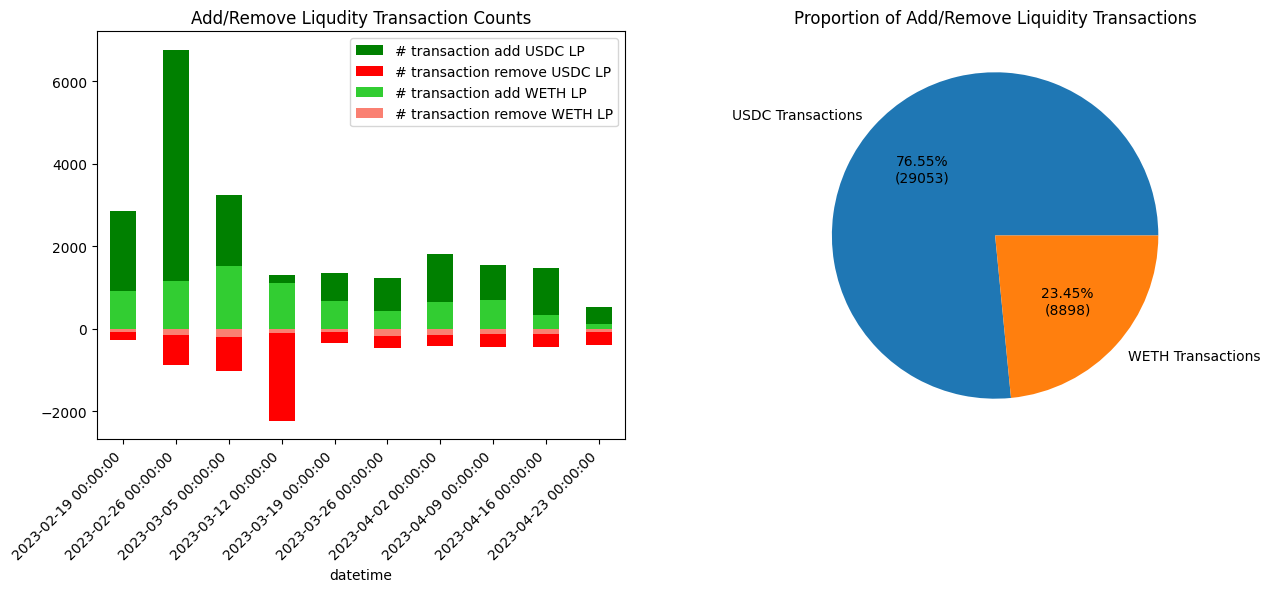

In [11]:



fig, ax = plt.subplots(1, 2, figsize=(15, 6))

usdc_txn[(usdc_txn["action"] == "mint")].resample("W")["token_amount"].count().plot.bar(ax=ax[0], color="green", label="# transaction add USDC LP")
usdc_txn[(usdc_txn["action"] == "burn")].resample("W")["token_amount"].count().map(lambda x: -x).plot.bar(ax=ax[0], color="red", label="# transaction remove USDC LP")
weth_txn[(weth_txn["action"] == "mint")].resample("W")["token_amount"].count().plot.bar(ax=ax[0], color="limegreen", label="# transaction add WETH LP")
weth_txn[(weth_txn["action"] == "burn")].resample("W")["token_amount"].count().map(lambda x: -x).plot.bar(ax=ax[0], color="salmon", label="# transaction remove WETH LP")
ax[0].set_title("Add/Remove Liqudity Transaction Counts")
# ax.tick_params(axis='x', labelrotation = -30)
fig.autofmt_xdate(rotation=45)

values = [len(usdc_txn), len(weth_txn)]
ax[1].pie(
    values, 
    labels=["USDC Transactions", "WETH Transactions"], 
    autopct=make_autopct(values))
ax[1].set_title("Proportion of Add/Remove Liquidity Transactions")

ax[0].legend()
plt.show()

### Multiple Chain Providers

In [59]:
user_chains = all_chains_data[all_chains_data["action"].isin(["mint", "burn"])].groupby("user_address")["chain"].nunique().sort_values(ascending=False)

In [65]:
y[0] / y.sum(), y[1:].sum() / y.sum()

(0.8402014897379562, 0.15979851026204384)

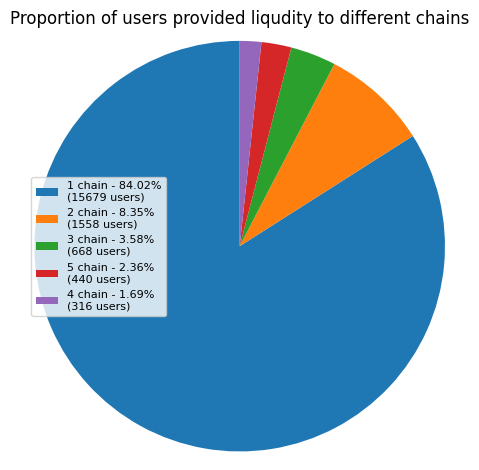

In [60]:
x = user_chains.value_counts().index
y = user_chains.value_counts().values

percent = 100. * y / sum(y)

patches, texts = plt.pie(y, startangle=90, radius=1.2)
labels = [
    f"{xi} chain - {_pct:1.2f}%\n({_v} users)"
    for xi, _pct, _v in zip(x, percent, y)]

patches, labels, dummy =  zip(
    *sorted(
        zip(patches, labels, y),
        key=lambda x: x[2],
        reverse=True))

plt.legend(
    patches, 
    labels, 
    loc="center left",
    fontsize=8)

plt.title("Proportion of users provided liqudity to different chains")
plt.tight_layout()
plt.show()

In [14]:
total_user_balance = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

for _user in tqdm(all_chains_data["user_address"].unique(), desc="Analyzing users"):
    for token in LP_TOKENS:
        for chain in CHAINS:

            user_tx = all_chains_data[
                (all_chains_data["user_address"] == _user) & \
                (all_chains_data["chain"] == Chain.resolve_connext_domain(chain)) & \
                (all_chains_data["token"] == token)
            ]

            if len(user_tx) == 0:
                continue

            chain_balance = user_tx["balance_change"].cumsum().values[-1]
            total_user_balance[_user][Chain.resolve_connext_domain(chain)][token] = chain_balance

Analyzing users:   0%|          | 0/19132 [00:00<?, ?it/s]

In [28]:
for _addr, _u in total_user_balance.items():
    
    for _c, _p in _u.items():
        if _p[Token.CUSDCLP] < -1e-10:
            print(Token.CUSDCLP, _c, _addr, _p[Token.CUSDCLP])
        elif _p[Token.CWETHLP] < -1e-10:
            print(Token.CWETHLP, _c, _addr, _p[Token.CWETHLP])

In [36]:
user_balances_num_chain = defaultdict(lambda: defaultdict(list))

for _addr, _u in total_user_balance.items():
    n_chain = len(_u)
    for _c, _p in _u.items():
        for _token in LP_TOKENS:
            user_balances_num_chain[n_chain][_token].append(_p[_token])

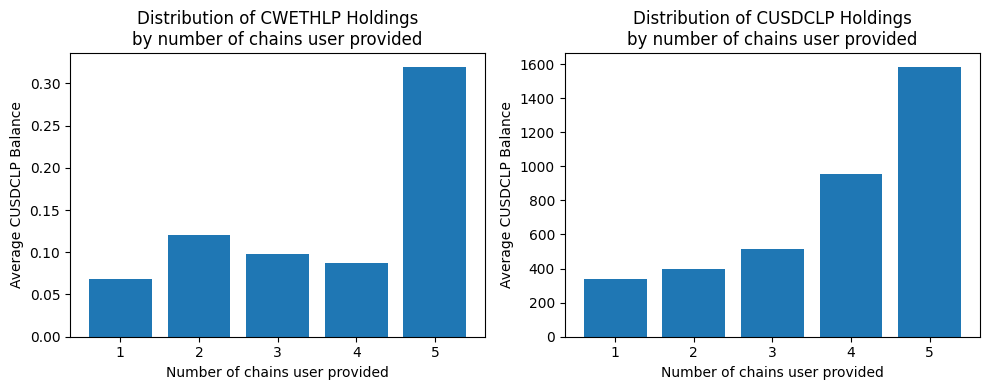

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i, _token in enumerate(LP_TOKENS):
    ax[i].bar(
        user_balances_num_chain.keys(),
        [np.mean(_b[_token]) for _b in user_balances_num_chain.values()]
    )
    ax[i].set_ylabel(f"Average {token} Balance")
    ax[i].set_xlabel("Number of chains user provided")
    ax[i].set_title(f"Distribution of {_token} Holdings\nby number of chains user provided")
plt.tight_layout()
plt.show()

### Comparing each chain

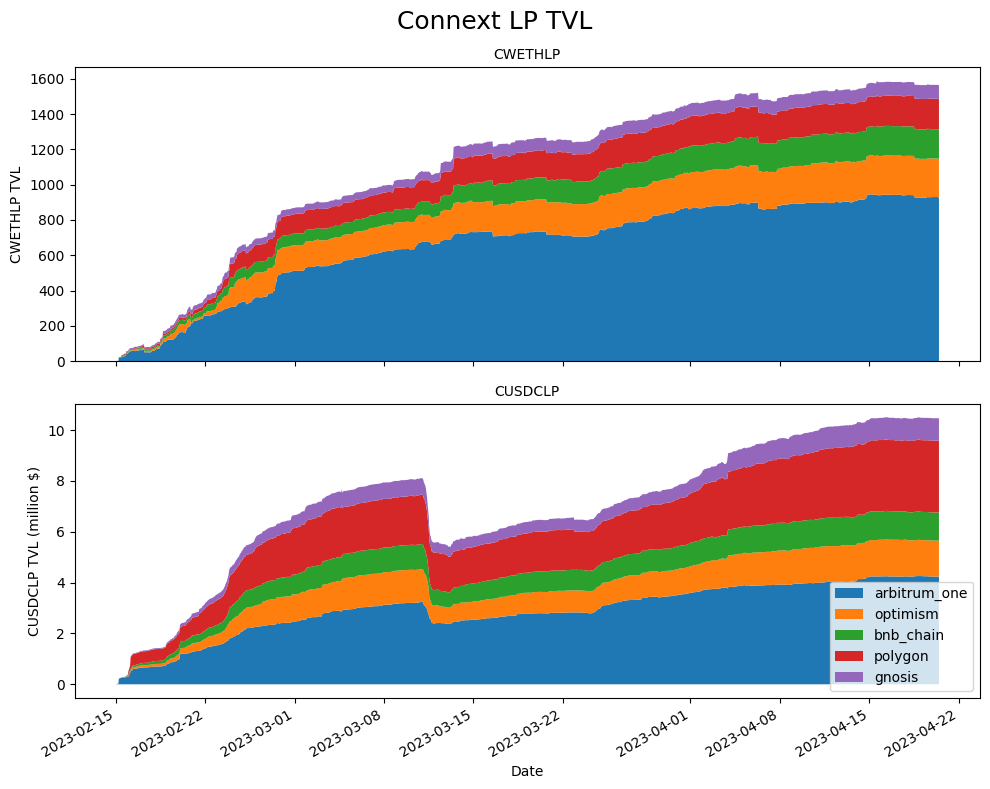

In [294]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ys = {token: [] for token in LP_TOKENS}
for i, token in enumerate(LP_TOKENS):
    labels = []
    for chain in CHAINS:
        df = dataset[chain]

        token_txn = df[df["token"] == token]
        token_txn = token_txn[token_txn["datetime"] >= CAMPAIGN_START_DATETIME]\
            .set_index("datetime")
        token_txn["balance_change"] = token_txn["token_amount"].copy() * token_txn["action"].copy().map(lambda x: 1 if x in ["mint", "transfer_in"] else -1)
        token_txn = pd.concat([token_txn, pd.DataFrame([{
            "chain": "",
            "hash": "",
            "user_address": _user,
            "token": "",
            "token_amount": 0,
            "action": "",
            "balance_change": 0
        }, {
            "chain": "",
            "hash": "",
            "user_address": _user,
            "token_amount": 0,
            "action": "",
            "token": "",
            "balance_change": 0
        }], index=[CAMPAIGN_START_DATETIME, LATEST_DATE])], axis=0).sort_index()


        mint_txn = token_txn[token_txn["action"].isin(["mint", ""])]
        burn_txn = token_txn[token_txn["action"].isin(["burn", ""])]

        yi = mint_txn["balance_change"].resample("1H").sum().cumsum() + burn_txn["balance_change"].resample("1H").sum().cumsum()
        x = yi.index
        ys[token].append(yi if token == Token.CWETHLP else yi/1e6)
        labels.append(Chain.resolve_connext_domain(chain))
    
    ax[i].stackplot(x, *ys[token], labels=labels)
    if token == Token.CUSDCLP:
        ax[i].set_ylabel(f"{token} TVL (million $)")
    else:
        ax[i].set_ylabel(f"{token} TVL")
    
    fig.autofmt_xdate()
    ax[i].set_title(token, fontsize=10)

ax[i].legend(
    loc="lower right"
)
ax[i].set_xlabel("Date")
fig.suptitle("Connext LP TVL", fontsize=18)
plt.tight_layout()
plt.show()

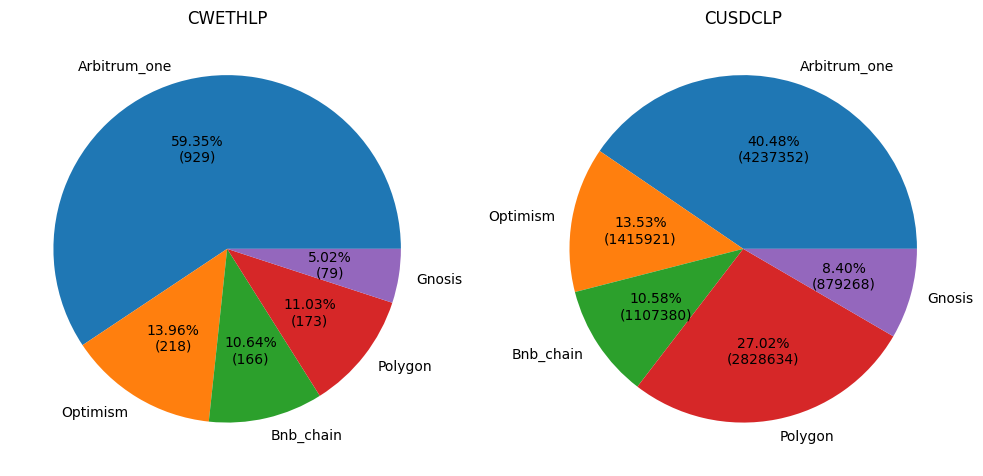

In [298]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i, token in enumerate(LP_TOKENS):
    values = [_item.values[-1] if token == Token.CWETHLP else _item.values[-1]*1e6 for _item in ys[token]]
    ax[i].pie(values, autopct=make_autopct(values), labels=list(map(lambda x: Chain.resolve_connext_domain(x).capitalize(), CHAINS)))
    ax[i].set_title(token)

plt.tight_layout()
plt.show()

In [277]:
def group_token_choices(tokens: List[Token]):
    if len(tokens.unique()) == 2:
        return "Both USDC and WETH"
    elif len(tokens.unique()) == 1:
        if tokens.unique()[0] == Token.CUSDCLP:
            return "USDC Only"
        else:
            return "WETH Only"

values = user_balances[user_balances["balance_change"] > MIN_VALUE].groupby(["user_address"], as_index=False)["token"].apply(group_token_choices)["token"].value_counts()

Text(0.5, 1.0, 'User Asset of Choice for LPing')

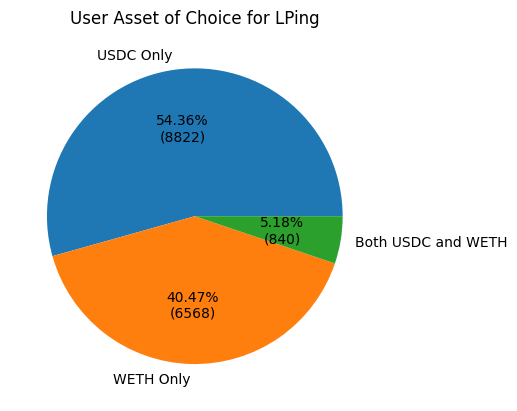

In [279]:
plt.pie(values.values, labels=values.index, autopct=make_autopct(values.values))
plt.title("User Asset of Choice for LPing")

## Sybil Analysis

In [122]:
all_chains_data[all_chains_data["hash"] == "0x7ab7af7e4cca79a3919a3d4e808fed198ed405ed44ed8f98d666b86963ff3e17"]

,chain,hash,user_address,token,token_amount,action,balance_change
datetime,,,,,,,
2023-02-23 13:48:00,gnosis,0x7ab7af7e4cca79a3919a3d4e808fed198ed405ed44ed...,0xbb0ee7a6e88ad93d2ef171d42478a783a4b292be,CUSDCLP,0.000001,transfer_in,0.000001
2023-02-23 13:48:00,gnosis,0x7ab7af7e4cca79a3919a3d4e808fed198ed405ed44ed...,0x73d5fd068478c4e23942ed78eaea612c700bcc44,CUSDCLP,0.000001,transfer_in,0.000001
2023-02-23 13:48:00,gnosis,0x7ab7af7e4cca79a3919a3d4e808fed198ed405ed44ed...,0x429968a3b75960fdc8ed95b615a841faaf32620f,CUSDCLP,0.000001,transfer_in,0.000001
2023-02-23 13:48:00,gnosis,0x7ab7af7e4cca79a3919a3d4e808fed198ed405ed44ed...,0xd5db3b46b880082f3d55f02ffef37214a090c246,CUSDCLP,0.000001,transfer_in,0.000001
2023-02-23 13:48:00,gnosis,0x7ab7af7e4cca79a3919a3d4e808fed198ed405ed44ed...,0x2551b5b6ff22c128c7ea18be99f8f647aa8257e1,CUSDCLP,0.000001,transfer_in,0.000001
...,...,...,...,...,...,...,...
2023-02-23 13:48:00,gnosis,0x7ab7af7e4cca79a3919a3d4e808fed198ed405ed44ed...,0x14adeab768b43b3783d3636f0176bce5578df543,CUSDCLP,0.000001,transfer_in,0.000001
2023-02-23 13:48:00,gnosis,0x7ab7af7e4cca79a3919a3d4e808fed198ed405ed44ed...,0x218403989068f758ff4aeebe58c97a68ed9d81d4,CUSDCLP,0.000001,transfer_in,0.000001
2023-02-23 13:48:00,gnosis,0x7ab7af7e4cca79a3919a3d4e808fed198ed405ed44ed...,0xa5e3437de354ff5acdb58ac7191fae95bc91b7c7,CUSDCLP,0.000001,transfer_in,0.000001


In [160]:
def get_tx_url(chain, tx_hash):
    if chain == "gnosis":
        return f"https://gnosisscan.io/tx/{tx_hash}"
    elif chain == "arbitrum_one":
        return f"https://arbiscan.io/tx/{tx_hash}"
    elif chain == "polygon":
        return f"https://polygonscan.com/tx/{tx_hash}"
    elif chain == "optimism":
        return f"https://optimistic.etherscan.io/tx/{tx_hash}"
    elif chain == "bnb_chain":
        return f"https://bscscan.com/tx/{tx_hash}"
    return (chain, tx_hash)

In [163]:
[get_tx_url(_chain, _hash) for (_chain, _hash), _count in all_chains_data[all_chains_data["action"] == "transfer_in"][["chain", "hash"]].value_counts().items() if _count > 10]

['https://gnosisscan.io/tx/0x7ab7af7e4cca79a3919a3d4e808fed198ed405ed44ed8f98d666b86963ff3e17',
 'https://bscscan.com/tx/0x4912307921a53e7aa6d092b6af7f3e22ad31e975ae8b69c8e7d9ee9ba34eda45',
 'https://bscscan.com/tx/0x44fd3665d2949ec56ac94105b1f30915ff7c998a5f86daea7de8c56244dccb8b',
 'https://polygonscan.com/tx/0xd5c80c68ee98b0d3e9c9f776cf2c0284a73fe10436770b03041d55706ff0bff4',
 'https://optimistic.etherscan.io/tx/0xe7930d4274743fb3bccb39f94a83dd00890b2c81e3ff2f9bfb21fd1c0ed7f1b1',
 'https://bscscan.com/tx/0x1a4613d1f0bf5a251504e3ed31ef84140c3087027df9632033c63ec33f080fb1',
 'https://arbiscan.io/tx/0x8916f8f96a6e86262221d2a484273b2779287253df820326460163c3412cad30',
 'https://polygonscan.com/tx/0x908dce092ac4810c57ce3e9ef636292c18d5c22e132049cb08ddba4664144775',
 'https://optimistic.etherscan.io/tx/0x4686f184a26a09b396de468cf6dd055767fbb8f27b833070c39076ef313a8f4e',
 'https://polygonscan.com/tx/0x83a49f9144a5be852419e238a9a8659c0df26968d17dda5863b6bb825b7215dc',
 'https://polygonscan.

In [166]:
all_chains_data[all_chains_data["user_address"] == "0x3e803b3713547f9c527bb257820b69a7c2a589c8"]

,chain,hash,user_address,token,token_amount,action,balance_change
datetime,,,,,,,
2023-02-23 19:07:52,optimism,0xd993ca743e5667960efcf788d68732c450280a470b95...,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,1048.302515,mint,1048.302515
2023-02-23 20:45:47,polygon,0xb0099548f1b42d66083407a76c57edfcedf14c69b358...,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,474.427290,mint,474.427290
2023-02-23 21:21:01,bnb_chain,0xb63effb42e42ece6a63e3d84d6160d826879586a67a4...,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,1765.642736,mint,1765.642736
2023-02-23 21:53:14,arbitrum_one,0xcee4fe2f88eb56443248b480f0c92d5b5de61916fdea...,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,755.388096,mint,755.388096
2023-03-05 15:12:27,optimism,0xb7c9d43f1d362b7f5f89d60f97223d7f0f83fb783bb7...,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,1052.295551,transfer_in,1052.295551
2023-03-05 15:12:27,optimism,0x9a7f51d2c97f12d54dfcaa5cb9d0e8cc98c0f5650091...,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,1050.298761,transfer_in,1050.298761
2023-03-05 15:12:42,optimism,0x3ce42791eae1491cbfbe5eb63c1be1f90c65e516e396...,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,1056.285363,transfer_in,1056.285363
2023-03-05 15:12:42,optimism,0xce52efcbb76e566f3b4fb37b409024744cb7f0267fc1...,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,1054.296216,transfer_in,1054.296216
2023-03-05 15:14:32,bnb_chain,0x17388a2c07fe586bb25d7d436fb964d5b1896a0eab9c...,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,1771.577040,transfer_in,1771.577040


In [171]:
all_chains_data[
    all_chains_data["hash"].isin(
        [_hash for (_chain, _hash), _count in all_chains_data[all_chains_data["action"] == "transfer_in"][["chain", "hash"]].value_counts().items() if _count > 10]
    ) & \
    ~(all_chains_data["user_address"].isin([
        "0x692b5a7ecccad243a07535e8c24b0e7433238c6a",  # disperse smart contract address
        "0xd152f549545093347a162dce210e7293f1452150"
    ])) & \
    all_chains_data["action"].isin(["transfer_out"])
].sort_values("balance_change").groupby(["chain", "user_address", "token"], as_index=False)["balance_change"].sum().sort_values("user_address")

,chain,user_address,token,balance_change
1,bnb_chain,0x26daee818a1e38a46825fafb8a729a1c021cc726,CUSDCLP,-2254.000000
5,optimism,0x26daee818a1e38a46825fafb8a729a1c021cc726,CUSDCLP,-20910.000000
8,polygon,0x26daee818a1e38a46825fafb8a729a1c021cc726,CUSDCLP,-18790.000000
0,arbitrum_one,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,-7820.000000
2,bnb_chain,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,-9020.000000
6,optimism,0x3e803b3713547f9c527bb257820b69a7c2a589c8,CUSDCLP,-7280.000000
3,bnb_chain,0x62f861c4732851870706a1f6b36f29b55f8181b2,CUSDCLP,-0.004000
4,gnosis,0x62f861c4732851870706a1f6b36f29b55f8181b2,CUSDCLP,-0.000499
7,optimism,0xa330edeb788fc80ee7d7d72bc4c296db4a803a73,CUSDCLP,-6536.000000
9,polygon,0xa330edeb788fc80ee7d7d72bc4c296db4a803a73,CUSDCLP,-3686.000000


## Simutenously Add Liquidity

In [ ]:
token = Token.CUSDCLP
transfer_only_users = [
    (k, v[Token.CUSDCLP]) 
    for k, v in user_txs.items() 
    if (
        (len(set(v[token]["action"].unique().tolist()) - {"transfer_in", "transfer_out"}) == 0) and \
        len(v[token]) > 0
    )]